In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy import signal as sg
from datetime import datetime as dt

### ay data need to be in the NetCDF before the debiasing the ACS chl
#### Note: this is based on the NASA HPLC xls file for AMT29

In [2]:
%matplotlib notebook

In [4]:
def prcrng(x):
    return (np.nanpercentile(x,84) - np.nanpercentile(x,16))/2.

In [5]:
# this is to make the Jupyter notebook as wide as the screen (on the Mac at least)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%config InlineBackend.figure_format ='retina'


In [6]:
DIN_hplc = "/data/datasets/cruise_data/active/AMT22/OSU/AMT22_HPLC/"
DIN_acs = "/users/rsg/tjor/scratch_network/AMT_underway/AMT22/Processed/Step3/"

In [7]:
fn_hplc =  "Behrenfeld_02-14_report.xlsx"
#fn_meta = "Filtering-Log-HPLC-AMT25_reformat.xlsx"
fn_optics = "amt22_final.nc"

In [8]:
print(DIN_hplc + fn_hplc)

df_hplc = df_hplc = pd.read_excel(DIN_hplc + fn_hplc, sheet_name = "Report", header = 8, engine = 'openpyxl')
df_hplc.keys()

print(df_hplc.keys())

# df_hplc

/data/datasets/cruise_data/active/AMT22/OSU/AMT22_HPLC/Behrenfeld_02-14_report.xlsx
Index(['GSFC Lab sample code', 'PI', 'Original PI Sample Label', 'Cruise Name',
       'Sequential Sample Number', 'Indicate if filters are replicates',
       'Volume filtered (ml)', 'Station', 'Bottle Number',
       'Sampling Depth (meters)', 'Total Water Depth (meters)',
       'Name of Water Body', 'Water Type',
       'collected with positive pressure or vaccuum', 'Year of Sample',
       'Gregorian Month', 'Day of Gregorian Month', 'Sequential Day of Year',
       'GMT Time', 'Longitude', 'Latitude', 'Filter type',
       'Filter Diameter (mm)', 'Filter storage before shipping to GSFC',
       'date extracted (month/day/year)', 'Vx (ml)', '[Tot_Chl_a]',
       '[Tot_Chl_b]', '[Tot_Chl_c]', '[Alpha_beta_Car]', '[But fuco]',
       '[Hex fuco]', '[Allo]', '[Diadino]', '[Diato]', '[Fuco]', '[Perid]',
       '[Zea]', '[MV_Chl_a]', '[DV_Chl_a]', '[Chlide_a]', '[MV_Chl _b]',
       '[DV_Chl_b]', '[Chl 

In [9]:
# NO HPLC META DATA IN AMT24


#print(DIN_hplc + fn_meta)
#df_meta = pd.read_excel(DIN_hplc + fn_meta, header = 0)
#df_meta.keys()
#list(df_meta['NAME'])


#label = []; # match sample/name ID between meta and hplc file
#for i in range(len(df_meta)):
 #   old_string = (str(df_meta['NAME'][i]))
  #  new_string = old_string.replace(":", "" )
   # label.append(new_string)

#df_meta['Label'] = label


#print(df_meta['Label'])

In [10]:
# merge two tables to extract info from df_meta

# NASA METADATA ALREADY INCLUDED IN SHEET

#print(df_hplc['Label'])
#print(df_meta['Label'])

#df_hplc = pd.merge(df_hplc, df_meta, on=['Label'])

#sorted(df_hplc.keys())

In [11]:
# convert PML pigment names to NASA pigment names for submission
#                            PML  :  NASA

#
#pml2nasa = {            
 #                         "[Allo]":"Allo",
  #                        "[Asta]": "Asta",
   #                       "[Anth]": "PML_only_Anth",
    #                  "[But fuco]":"But-fuco",
     #                     "[Caro]":"Alpha-beta-Car", # !!!! TO CHECK !!!
      #                   "[Chl a]":'Chl_a',
       #      "[Chl b] + [DVChl b]":"PML_only_Chl_b_DVChl_b",
        #                '[Chl c1]':'Chl_c1',
         #               '[Chl c2]':'Chl_c2',
          #              '[Chl-c3]':'Chl_c3',
           #           "[Chlide a]":"Chlide_a",
            #              "[Diad]":"Diadino",
            #             "[Diato]":"Diato",
             #          "[DVChl a]":"DV_Chl_a",
             #             "[Fuco]":"Fuco",
              #        "[Hex fuco]":"Hex-fuco",
              #             "[Lut]":"Lut",
                        # '[MgDVP]':'Mg_DVP', - present in AMT 26 and AMT 25, but not AMT 24
               #            '[Neo]':'Neo',
               #            "[PPC]":"PPC",
               #            "[PSC]":"PSC",
               #            "[PSP]":"PSP",
               #          "[Perid]":"Perid",
               #           "[Pras]":"Pras",
               #            "[Zea]":"Zea",
               #           "[TAcc]":"Tacc",
               #           "[TChl]":"TChl",
               #         "[TChl a]":"Tot_Chl_a",
               #         "[TChl b]":"Tot_Chl_b",
               #         "[TChl c]":"Tot_Chl_c",
               #           '[TPig]': "Tpg",
               #          '[Viola]':'Viola',
               #         '[ββ-Car]':"beta-beta-Car",
               #         '[βε-Car]':"beta-epi-Car",                  
            
          # }
#                     "a-carotene":"Alpha-beta-Car", # these two successive pigments need to be merged (see below)
#                     "b-carotene":"Alpha-beta-Car"}

# rename DHI columns with NASA names
# df_hplc = df_hplc.rename(columns = pml2nasa)

# create merged pigments
# "Alpha-beta-Car", 
#df_hplc["Alpha-beta-Car"] = df_hplc["a-carotene"] + df_hplc["b-carotene"] - ALREADY IN MERGED FORMAT
#df_hplc = df_hplc.drop(columns=["a-carotene", "b-carotene"]) - 
           
# "Chl c1c2"
#df_hplc["Chl_c1c2"] = df_hplc["Chl_c2"] + df_hplc["Chl_c1"]  +df_hplc["Mg_DVP"]- cannot defined for AMT24 as Mg_DVP not present.

# "Tot_Chl_a" = DV_Chl_a + MV_Chl_a + Chlide_a (+ Chl_a allomers + Chl_a epimers)   - ALREADY IN MERGED FORMAT
#df_hplc["Tot_Chl_a"] = df_hplc["DV_Chl_a"] + df_hplc["MV_Chl_a"] + df_hplc["Chlide_a"]

# "Tot_Chl_c" = Tot_Chl_a + Tot_Chl_b + Tot_Chl_c - ALREADY IN MERGED FORMAT
#df_hplc["Tot_Chl_c"] = df_hplc["Chl_c3"] + df_hplc["Chl_c1c2"]

# "Tchl" = Tot_Chl_a + Tot_Chl_b + Tot_Chl_c - ALREADY IN MERGED FORMAT
#df_hplc["Tchl"] = df_hplc["Tot_Chl_a"] + df_hplc["Tot_Chl_b"] + df_hplc["Tot_Chl_c"]

# "PPC" (photoprotective carotenoids) = allo + diadino + diato + zea + alpha-beta-car)
#f_hplc["PPC"] = df_hplc["Allo"] + df_hplc["Diadino"] + df_hplc["Diato"] + df_hplc["Zea"] + df_hplc["Alpha-beta-Car"]

# "PSC" (photosynthetic carotenoids) = but-fuco + fuco + hex-fuco + perid
#df_hplc["PSC"] = df_hplc["But-fuco"] + df_hplc["Fuco"] + df_hplc["Hex-fuco"] + df_hplc["Perid"] 

# "PSP" (phosynthetic pigments) = PSC + TChl
#df_hplc["PSP"] = df_hplc["PSC"] + df_hplc["Tchl"] 

# "Tcar" (total carotenoids) = PPC + PSC
# df_hplc["Tcar"] = df_hplc["PPC"] + df_hplc["PSC"] 

# "Tacc" (total accessory pigments) = PPC + PSC + Tot_Chl_b + Tot_Chl_c  - ALREADY IN MERGED FORMAT
#df_hplc["Tacc"] = df_hplc["PPC"] + df_hplc["PSC"] + df_hplc["Tot_Chl_b"] + df_hplc["Tot_Chl_c"] 

# "Tpg" (total pigments) = TAcc + Tot_Chl_a - ALREADY IN MERGED FORMAT
#df_hplc["Tpg"] = df_hplc["Tacc"] + df_hplc["Tot_Chl_a"] 

# "DP" (total diagnostic pigments) = PSC + allo + zea + Tot_Chl_b
# df_hplc["DP"] = df_hplc["PSC"] + df_hplc["Allo"] + df_hplc["Zea"] + df_hplc["Tot_Chl_b"]


# new dictionary with additional pigments
#derived_pigs = {#"Alpha-beta-Car":"Alpha-beta-Car",
               # "Chl_c1c2":"Chl_c1c2",
               # "Tot_Chl_a":"Tot_Chl_a", - already added
               # "Tot_Chl_c":"Tot_Chl_c",
                #"Tchl":"Tchl",
                #"PPC":"PPC",
                #"PSC":"PSC",
                #"PSP":"PSP",
            #    "Tcar":"Tcar",
         #       "DP":"DP"      }


# drop pigment ratios 

#df_hplc.keys()



In [12]:
# drop pigment ratios 
#df_hplc = df_hplc.drop('void1') # redumdant
#df_hplc = df_hplc.drop('[PPC]/[Tpig]') # redumdant
#df_hplc = df_hplc.drop('[PSP]/[TPig]') # redumdant
#df_hplc = df_hplc.drop('[TChl a]/[TPig]') # redumdant

#df_hplc['[TAcc]/[Tchla]'] =[]

In [13]:
# merge dictonaries with names of all pigments
#all_pigs = dict(pml2nasa, **derived_pigs)

#print(all_pigs)
df_hplc.keys()

Index(['GSFC Lab sample code', 'PI', 'Original PI Sample Label', 'Cruise Name',
       'Sequential Sample Number', 'Indicate if filters are replicates',
       'Volume filtered (ml)', 'Station', 'Bottle Number',
       'Sampling Depth (meters)', 'Total Water Depth (meters)',
       'Name of Water Body', 'Water Type',
       'collected with positive pressure or vaccuum', 'Year of Sample',
       'Gregorian Month', 'Day of Gregorian Month', 'Sequential Day of Year',
       'GMT Time', 'Longitude', 'Latitude', 'Filter type',
       'Filter Diameter (mm)', 'Filter storage before shipping to GSFC',
       'date extracted (month/day/year)', 'Vx (ml)', '[Tot_Chl_a]',
       '[Tot_Chl_b]', '[Tot_Chl_c]', '[Alpha_beta_Car]', '[But fuco]',
       '[Hex fuco]', '[Allo]', '[Diadino]', '[Diato]', '[Fuco]', '[Perid]',
       '[Zea]', '[MV_Chl_a]', '[DV_Chl_a]', '[Chlide_a]', '[MV_Chl _b]',
       '[DV_Chl_b]', '[Chl c12]', '[Chl_c3]', '[Lut]', '[Neo]', '[Viola]',
       '[Phytin_a]', '[Phide_a]', '[

In [14]:
# find matching keys and merge them into a single one
for key in df_hplc.keys():
    if "_x" in key:
        print(key)

        if ~(np.all(df_hplc[key] == df_hplc[key[:-1]+"y"])):
            print([key, " not matching"])
        else:
            # drop *_x key
            print(["droppping " + key ])
            df_hplc = df_hplc.drop(columns = [key])
            # rename *_y key
            print(["renaming " + key ])
            df_hplc = df_hplc.rename(columns = {key[:-1]+"y" : key[:-2]})
            

In [15]:
# clean up of key labels from older nasa format for amt 22
for key in df_hplc.keys():
    if "[" in key:
        print(key)
        print(key[1:-1])
        df_hplc = df_hplc.rename(columns = {key : key[1:-1]})

        # clean up of key labels from older nasa format for amt 22
for key in df_hplc.keys():
    if "]/[" in key: 
        
        df_hplc = df_hplc.drop(columns = {key})



[Tot_Chl_a]
Tot_Chl_a
[Tot_Chl_b]
Tot_Chl_b
[Tot_Chl_c]
Tot_Chl_c
[Alpha_beta_Car]
Alpha_beta_Car
[But fuco]
But fuco
[Hex fuco]
Hex fuco
[Allo]
Allo
[Diadino]
Diadino
[Diato]
Diato
[Fuco]
Fuco
[Perid]
Perid
[Zea]
Zea
[MV_Chl_a]
MV_Chl_a
[DV_Chl_a]
DV_Chl_a
[Chlide_a]
Chlide_a
[MV_Chl _b]
MV_Chl _b
[DV_Chl_b]
DV_Chl_b
[Chl c12]
Chl c12
[Chl_c3]
Chl_c3
[Lut]
Lut
[Neo]
Neo
[Viola]
Viola
[Phytin_a]
Phytin_a
[Phide_a]
Phide_a
[Pras]
Pras
[Gyro]
Gyro
[TChl]
TChl
[PPC]
PPC
[PSC]
PSC
[PSP]
PSP
[TCaro]
TCaro
[TAcc]
TAcc
[TPg]
TPg
[DP]
DP
[TAcc]/[Tchla]
TAcc]/[Tchla
[PSC]/[TCaro]
PSC]/[TCaro
[PPC]/[TCaro]
PPC]/[TCaro
[TChl]/[TCaro]
TChl]/[TCaro
[PPC]/[Tpig]
PPC]/[Tpig
[PSP]/[TPg]
PSP]/[TPg
[TChl a]/[TPig]
TChl a]/[TPig


In [16]:

df_hplc = df_hplc.rename(columns = {'Alpha_beta_Car' : 'Alpha-beta-Car'})

df_hplc = df_hplc.rename(columns = {'But fuco' : 'But-fuco'})

df_hplc = df_hplc.rename(columns = {'Hex fuco' : 'Hex-fuco'})

df_hplc = df_hplc.rename(columns = {'Chl c12' : 'Chl_c12'})


In [17]:
df_hplc.keys() 

Index(['GSFC Lab sample code', 'PI', 'Original PI Sample Label', 'Cruise Name',
       'Sequential Sample Number', 'Indicate if filters are replicates',
       'Volume filtered (ml)', 'Station', 'Bottle Number',
       'Sampling Depth (meters)', 'Total Water Depth (meters)',
       'Name of Water Body', 'Water Type',
       'collected with positive pressure or vaccuum', 'Year of Sample',
       'Gregorian Month', 'Day of Gregorian Month', 'Sequential Day of Year',
       'GMT Time', 'Longitude', 'Latitude', 'Filter type',
       'Filter Diameter (mm)', 'Filter storage before shipping to GSFC',
       'date extracted (month/day/year)', 'Vx (ml)', 'Tot_Chl_a', 'Tot_Chl_b',
       'Tot_Chl_c', 'Alpha-beta-Car', 'But-fuco', 'Hex-fuco', 'Allo',
       'Diadino', 'Diato', 'Fuco', 'Perid', 'Zea', 'MV_Chl_a', 'DV_Chl_a',
       'Chlide_a', 'MV_Chl _b', 'DV_Chl_b', 'Chl_c12', 'Chl_c3', 'Lut', 'Neo',
       'Viola', 'Phytin_a', 'Phide_a', 'Pras', 'Gyro', 'TChl', 'PPC', 'PSC',
       'PSP', 'TCar

In [18]:
# convert date (numpy.datetime64) and time (datetime.time) to a single datetime object
# convert date (numpy.datetime64) and time (datetime.time) to a single datetime object
from datetime import datetime as dt

date = [dt.strptime('2012' + str(df_hplc['Sequential Day of Year'][i]), '%Y%j').date() for i in range(len(df_hplc))]
print(date)


df_hplc['GMT Time'][0]

time_inday =  [dt.strptime(str(df_hplc['GMT Time'][i]), '%H%M').time() for i in range(len(df_hplc))]
print(time_inday)

# add Time object to Date object to get DateTime object
datetime = [dt.combine(date[i],time_inday[i]) for i in range(len(df_hplc))]
print(datetime)

# create "Time" key in df_hplc
#
df_hplc['time'] = datetime

#df_hplc.keys()




[datetime.date(2012, 10, 11), datetime.date(2012, 10, 12), datetime.date(2012, 10, 12), datetime.date(2012, 10, 12), datetime.date(2012, 10, 12), datetime.date(2012, 10, 13), datetime.date(2012, 10, 13), datetime.date(2012, 10, 14), datetime.date(2012, 10, 14), datetime.date(2012, 10, 14), datetime.date(2012, 10, 14), datetime.date(2012, 10, 15), datetime.date(2012, 10, 15), datetime.date(2012, 10, 15), datetime.date(2012, 10, 15), datetime.date(2012, 10, 15), datetime.date(2012, 10, 15), datetime.date(2012, 10, 16), datetime.date(2012, 10, 16), datetime.date(2012, 10, 16), datetime.date(2012, 10, 16), datetime.date(2012, 10, 17), datetime.date(2012, 10, 17), datetime.date(2012, 10, 17), datetime.date(2012, 10, 17), datetime.date(2012, 10, 17), datetime.date(2012, 10, 17), datetime.date(2012, 10, 17), datetime.date(2012, 10, 17), datetime.date(2012, 10, 18), datetime.date(2012, 10, 18), datetime.date(2012, 10, 18), datetime.date(2012, 10, 18), datetime.date(2012, 10, 18), datetime.date

In [19]:
# clean up lat
#tmpla = df_hplc['Lat'].values
#for i,la in enumerate(tmpla):
   # if (type(la) != float) & (type(la) != int):
#         print(type(la))
#         print(i, "    ", la)
        # assume the string is similar to "31°31.784'W"
        
        # replace "º" by "°"
     #   la = la.replace("º", "°")
        
    #    degrees = float(la.split("°")[0]) 
     #   minutes = float(la.split("°")[-1].split("'")[0])
    #    NoS = la.split("°")[-1].split("'")[-1]
     #   sign = -1
      #  if (NoS.upper() == "N"):
          #  sign = 1
       # df_hplc.at[i, 'Lat'] = sign*(degrees + minutes/60.)

# clean up lon
#tmplo = df_hplc['Lon'].values
#for i,lo in enumerate(tmplo):
 #   if (type(lo) != float) & (type(lo) != int):
#         print(type(lo))
#         print(i, "    ", lo)
        # assume the string is similar to "31°31.784'"
        
        # replace "º" by "°"
  #      lo = lo.replace("º", "°")
        
   #     degrees = float(lo.split("°")[0]) 
    #    minutes = float(lo.split("°")[-1].split("'")[0])
     #   EoW = lo.split("°")[-1].split("'")[-1]
      #  sign = -1
      #  if (EoW.upper() == "E"):
       #     sign = 1
       # df_hplc.at[i, 'Lon'] = sign*(degrees + minutes/60.)
        
##df_hplc.rename(columns={'LAT': 'Lat'}, inplace = True)
#df_hplc.rename(columns={'LON': 'Lon'}, inplace = True)
#print(df_hplc.keys())
# 

In [20]:

#df_hplc = df_hplc[df_hplc['Indicate if filters are replicates'] !='D']   
#df_hplc = df_hplc.drop(columns=['Indicate if filters are replicates'])
#df_hplc = df_hplc.reindex()
#df_hplc

#['Indicate if filters are replicates'!='D']

#df_hplc = df_hplc.drop(df_hplc['Indicate if filters are replicates'=='D'].index)

# df_hplc = df_hplc.drop('Indicate if filters are replicates') # redumdant
# df_hplc['Indicate if filters are replicates']   


In [21]:
len(df_hplc)

226

In [22]:
# remove 1 micron filter data  - not needed for AMT26

#index_keep = [];
#for i in range(len(df_hplc_surf)):
#    if df_hplc_surf["Label"].iloc[i][-6:-1] != 'Micro':
 #       index_keep.append(i) 

#df_hplc_surf = df_hplc_surf.iloc[index_keep]
                        
              
#df_hplc_surf = df_hplc[isurf]
#df_hplc_surf = df_hplc_surf.set_index("time")
#df_hplc_surf

In [23]:
#index_keep = [];

#isurf = df_hplc["depth"]<10
#df_hplc_surf = df_hplc[isurf]
#df_hplc_surf = df_hplc_surf.set_index("time")
#df_hplc_surf
#df_hplc_surf = df_hplc.iloc[index_keep]

#df_hplc_surf = df_hplc_surf.set_index("time") # set index for time


# For AMT 22: 
df_hplc_surf = df_hplc


In [24]:
df_hplc_surf


,GSFC Lab sample code,PI,Original PI Sample Label,Cruise Name,Sequential Sample Number,Indicate if filters are replicates,Volume filtered (ml),Station,Bottle Number,Sampling Depth (meters),...,TChl,PPC,PSC,PSP,TCaro,TAcc,TPg,DP,comments,time
0,02-2608,"Behrenfeld, Mike",AMT22_F1_HPLCA,AMT22,1,0,2110.00,1,1,5,...,1.095,0.094,0.625,1.720,0.719,1.057,1.814,0.691,NaN,2012-10-11 18:25:00
1,02-2609,"Behrenfeld, Mike",AMT22_F2_HPLCA,AMT22,2,0,2110.00,2,1,5,...,0.545,0.097,0.275,0.820,0.372,0.537,0.917,0.373,NaN,2012-10-12 09:28:00
2,02-2610,"Behrenfeld, Mike",AMT22_F3_HPLCA,AMT22,3,0,2110.00,3,1,5,...,0.705,0.107,0.389,1.094,0.496,0.719,1.201,0.497,NaN,2012-10-12 15:21:00
3,02-2611,"Behrenfeld, Mike",AMT22_F3_HPLCB,AMT22,4,1,2107.52,3,1,5,...,0.693,0.107,0.383,1.076,0.490,0.708,1.183,0.491,NaN,2012-10-12 15:21:00
4,02-2612,"Behrenfeld, Mike",AMT22_F4_HPLCA,AMT22,5,0,2110.00,4,1,5,...,0.582,0.069,0.391,0.973,0.460,0.646,1.042,0.435,NaN,2012-10-12 21:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,02-2822,"Behrenfeld, Mike",AMT22_F192_HPLCA,AMT22,216,0,2110.00,192,1,5,...,0.819,0.233,0.406,1.225,0.639,0.872,1.458,0.607,NaN,2012-11-19 20:35:00
222,02-2823,"Behrenfeld, Mike",AMT22_F193_HPLCA,AMT22,217,0,2110.00,193,1,5,...,0.922,0.233,0.385,1.307,0.618,0.856,1.540,0.576,NaN,2012-11-20 04:06:00
223,02-2824,"Behrenfeld, Mike",AMT22_F194_HPLCA,AMT22,218,0,2110.00,194,1,5,...,1.401,0.267,0.773,2.174,1.040,1.437,2.441,0.967,NaN,2012-11-20 03:40:00
224,02-2825,"Behrenfeld, Mike",AMT22_F195_HPLCA,AMT22,219,0,2110.00,195,1,5,...,1.141,0.209,0.644,1.785,0.853,1.187,1.994,0.803,NaN,2012-11-20 07:18:00


In [25]:
#type(index_drop)
#df_hplc_surf.drop(index_drop,axis=0)
             
print(df_hplc_surf)

    GSFC Lab sample code                PI Original PI Sample Label  \
0                02-2608  Behrenfeld, Mike           AMT22_F1_HPLCA   
1                02-2609  Behrenfeld, Mike           AMT22_F2_HPLCA   
2                02-2610  Behrenfeld, Mike           AMT22_F3_HPLCA   
3                02-2611  Behrenfeld, Mike           AMT22_F3_HPLCB   
4                02-2612  Behrenfeld, Mike           AMT22_F4_HPLCA   
..                   ...               ...                      ...   
221              02-2822  Behrenfeld, Mike         AMT22_F192_HPLCA   
222              02-2823  Behrenfeld, Mike         AMT22_F193_HPLCA   
223              02-2824  Behrenfeld, Mike         AMT22_F194_HPLCA   
224              02-2825  Behrenfeld, Mike         AMT22_F195_HPLCA   
225              02-2826  Behrenfeld, Mike         AMT22_F196_HPLCA   

    Cruise Name  Sequential Sample Number  Indicate if filters are replicates  \
0         AMT22                         1                         

In [26]:
# read ACS data
fn_acs = fn_optics
fn_optics
DIN_acs + fn_acs
acs = xr.open_dataset(DIN_acs + fn_acs)
acs.close()


# replace uway_long with uway_lon
if "uway_long" in acs.keys():
    acs.uway_lon = acs.uway_long
    acs = acs.drop(labels="uway_long")

acs

list(acs.keys())

['flow',
 'acs_chl',
 'acs_ap',
 'acs_ap_u',
 'acs_bp',
 'acs_bp_u',
 'acs_cp',
 'acs_cp_u',
 'acs_N',
 'acs2_chl',
 'acs2_ap',
 'acs2_ap_u',
 'acs2_bp',
 'acs2_bp_u',
 'acs2_cp',
 'acs2_cp_u',
 'acs2_N',
 'ac9_chl',
 'ac9_ap',
 'ac9_ap_u',
 'ac9_bp',
 'ac9_bp_u',
 'ac9_cp',
 'ac9_cp_u',
 'ac9_N',
 'bb3_bbp',
 'bb3_bbp_err',
 'bb3_bb02',
 'bb3_bb02_err',
 'bb3_bbp_corr',
 'cstar_cp',
 'cstar_cp_err',
 'uway_lat',
 'uway_lon',
 'uway_smg',
 'uway_cmg',
 'uway_heading',
 'uway_log',
 'uway_uncdepth',
 'uway_cordepth',
 'uway_sst',
 'uway_conductivty',
 'uway_sal',
 'uway_fluo',
 'uway_trans',
 'uway_air_temp',
 'uway_pressure',
 'uway_humidity',
 'uway_ptir',
 'uway_stir',
 'uway_ppar',
 'uway_spar',
 'uway_wind_speed',
 'uway_wind_dir']

In [27]:
# fig, ax = plt.subplots(2,1, figsize=[12,6], sharex=True)
# ax[0].plot(acs.time, acs.uway_lon, '.')
# ax[1].plot(acs.time, acs.uway_lat, '.')


In [28]:
# 

### Add HPLC data to NetCDF file

In [29]:
# convert to lower case some keys in hplc dataframe
if "Lon" in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Lon":"lon"})
if "Lat" in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Lat":"lat"})
#if "Time" in  df_hplc_surf:
 #   df_hplc_surf = df_hplc_surf.rename(columns = {"Time":"time"}) # already done
if 'Depth (meters)' in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Sampling Depth (meters)":"depth"})

if "Longitude" in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Longitude":"lon"})
if "Latitude" in  df_hplc_surf:
    df_hplc_surf = df_hplc_surf.rename(columns = {"Latitude":"lat"})

In [30]:
df_hplc_surf.keys()

Index(['GSFC Lab sample code', 'PI', 'Original PI Sample Label', 'Cruise Name',
       'Sequential Sample Number', 'Indicate if filters are replicates',
       'Volume filtered (ml)', 'Station', 'Bottle Number',
       'Sampling Depth (meters)', 'Total Water Depth (meters)',
       'Name of Water Body', 'Water Type',
       'collected with positive pressure or vaccuum', 'Year of Sample',
       'Gregorian Month', 'Day of Gregorian Month', 'Sequential Day of Year',
       'GMT Time', 'lon', 'lat', 'Filter type', 'Filter Diameter (mm)',
       'Filter storage before shipping to GSFC',
       'date extracted (month/day/year)', 'Vx (ml)', 'Tot_Chl_a', 'Tot_Chl_b',
       'Tot_Chl_c', 'Alpha-beta-Car', 'But-fuco', 'Hex-fuco', 'Allo',
       'Diadino', 'Diato', 'Fuco', 'Perid', 'Zea', 'MV_Chl_a', 'DV_Chl_a',
       'Chlide_a', 'MV_Chl _b', 'DV_Chl_b', 'Chl_c12', 'Chl_c3', 'Lut', 'Neo',
       'Viola', 'Phytin_a', 'Phide_a', 'Pras', 'Gyro', 'TChl', 'PPC', 'PSC',
       'PSP', 'TCaro', 'TAcc',

In [31]:
# create hplc_time coordinate
acs = acs.assign_coords(coords={'hplc_time' : (['hplc_time'], df_hplc_surf.index, {'time zone' : 'UTC'}) })
acs.hplc_time.encoding['units'] = "seconds since 1970-01-01 00:00:00"
acs.hplc_time.encoding['calendar'] = "proleptic_gregorian"


In [32]:
# #### read HPLC metadata on pigments (if NASA)
hplc_pignm = pd.read_excel(DIN_hplc + fn_hplc, sheet_name = "information", header = 4, engine = 'openpyxl',
                         nrows = 38, usecols = [1, 3, 4, 12, 13, 14], dtype=str)

# # shift info around in original table
df1 = hplc_pignm.iloc[:, [0,1,2]]
df2 = hplc_pignm.iloc[:, [3,4,5]] 
df2 = df2.rename(columns={ df2.keys()[0]: 'abbreviation',
                      df2.keys()[1]: 'name',
                      df2.keys()[2]: 'notes'
                     })
df1 = df1.rename(columns={ df1.keys()[0]: 'abbreviation',
                      df1.keys()[1]: 'name',
                      df1.keys()[2]: 'notes'
                      })
# # concatenate to subsets of attributes
df1 = df1.append(df2, ignore_index=True)

# # find indices with empty abbreviations and drop them
ind = []
for irow in range(len(df1['abbreviation'].values)):
     if type(df1['abbreviation'].values[irow])==float:
         ind.append(irow)
    
df_hplc_pignm = df1.drop(ind)    


/tmp/ipykernel_305230/3106701258.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df1 = df1.append(df2, ignore_index=True)


In [33]:
# df_hplc.plot.scatter(x='lat', y='DV_Chl_b', xlim=(-60,60), ylim=(0,0.3), marker='o', grid='on', alpha=0.5)

In [34]:
### add HPLC variables to acs dataset
# drop time-related columns
df_hplc_surf = df_hplc_surf.drop(columns=['Total Water Depth (meters)', 'GMT Time' ])
#print(df_hplc_surf.keys())
#print(df_hplc_surf['Unnamed: 5'])

#df_hplc_surf = df_hplc_surf.drop(columns=['Unnamed: 5'])
                     #         'water_depth', 'name of water body' ])
    
        
#df_hplc_surf.rename(columns={'BOTTLE NO': 'bottle'}, inplace = True)

In [35]:
## for NASA only
df_hplc_pignm.abbreviation.values

array(['Allo', 'alpha-beta-Car', 'But-fuco', 'Diadino', 'Diato', 'Fuco',
       'Hex-fuco', 'Perid', 'Tot_Chl_a', 'Tot_Chl_b', 'Tot_Chl_c', 'Zea',
       'Chl_c3', 'Chlide_a', 'DV_Chl_a', 'DV_Chl_b', 'MV_Chl_a',
       'MV_Chl_b', 'Chl_c1c2', 'Lut', 'Neo', 'Phide_a', 'Phytin_a',
       'Pras', 'Viola', 'Gyro', 'DP', 'PPC', 'PPC_Tcar', 'PPC_Tpg', 'PSC',
       'PSC_Tcar', 'PSP', 'PSP_Tpg', 'Tacc', 'Tacc_Tchla', 'Tcar', 'Tchl',
       'Tchl_Tcar', 'Tchla_Tpg', 'Tpg'], dtype=object)

In [36]:
# if NASA

# # find names of hplc vars
# hplc_cols = df_hplc_surf.keys()
# #add attributes to each variable and add it to acs xr dataset
# _var = ()
# _attrs = {}
# for ivar in hplc_cols:
# #     print(ivar)
#     lbl = ivar.replace(" ", "_").replace("__", "_") # repalce spaces with _
#     print(lbl)
    
#     if 'diameter' in ivar:
#         lbl = lbl[:-5]
#         _attrs = {'units': 'mm'}
#         _var = (['hplc_time'], df_hplc[ivar] ) 
    
#     elif lbl in df_hplc_pignm['abbreviation'].values:
#         # find index of df_hplc_pignm ivar
#         ik = list(df_hplc_pignm['abbreviation']).index(lbl)
# #         print("^^^^^^^^^^^this is a pigment")
#         _attrs = {'units' : 'mg/m3',
#                   'full_pigment_name' : df_hplc_pignm['name'].values[ik],
#                   'notes' : df_hplc_pignm['notes'].values[ik]}
#         _var = (['hplc_time'], df_hplc[ivar])
# #             print(_var)
#     else:
# #         print('nothing to do: ' + ivar)
#         _attrs = {}
#         _var = (['hplc_time'], df_hplc[ivar]) 
        
        
#     acs['hplc_'+lbl] = _var
#     acs['hplc_'+lbl].attrs = _attrs
    
#     # reset _var and _attrs
#     _var = ()
#     _attras = {}
    
# #     print(lbl)


# ## HOW TO CHECK THAT ALL PIGMENTS HAVE HAD THEIR ATTRIBUTES?

In [37]:
#pigs_names = {value:key for key, value in all_pigs.items()} 
# pigs_names
df_hplc_surf.keys()

Index(['GSFC Lab sample code', 'PI', 'Original PI Sample Label', 'Cruise Name',
       'Sequential Sample Number', 'Indicate if filters are replicates',
       'Volume filtered (ml)', 'Station', 'Bottle Number',
       'Sampling Depth (meters)', 'Name of Water Body', 'Water Type',
       'collected with positive pressure or vaccuum', 'Year of Sample',
       'Gregorian Month', 'Day of Gregorian Month', 'Sequential Day of Year',
       'lon', 'lat', 'Filter type', 'Filter Diameter (mm)',
       'Filter storage before shipping to GSFC',
       'date extracted (month/day/year)', 'Vx (ml)', 'Tot_Chl_a', 'Tot_Chl_b',
       'Tot_Chl_c', 'Alpha-beta-Car', 'But-fuco', 'Hex-fuco', 'Allo',
       'Diadino', 'Diato', 'Fuco', 'Perid', 'Zea', 'MV_Chl_a', 'DV_Chl_a',
       'Chlide_a', 'MV_Chl _b', 'DV_Chl_b', 'Chl_c12', 'Chl_c3', 'Lut', 'Neo',
       'Viola', 'Phytin_a', 'Phide_a', 'Pras', 'Gyro', 'TChl', 'PPC', 'PSC',
       'PSP', 'TCaro', 'TAcc', 'TPg', 'DP', 'comments', 'time'],
      dtype='o

In [38]:
# Find names of hplc vars
hplc_cols = df_hplc_surf.keys()
# Add attributes to each variable and add it to acs xr dataset
_var = ()
_attrs = {}
for ivar in hplc_cols:
  #  print(ivar)
    lbl = ivar.replace(" ", "_").replace("__", "_") # repalce spaces with _
 #   print(lbl)
    
    if 'diameter' in ivar:
        lbl = lbl[:-5]
        _attrs = {'units': 'mm'}
        _var = (['hplc_time'], df_hplc[ivar]) 
    
    elif lbl in df_hplc_pignm['abbreviation'].values:
         # find index of df_hplc_pignm ivar
        ik = list(df_hplc_pignm['abbreviation']).index(lbl)
        print("^^^^^^^^^^^this is a pigment")
        _attrs = {'units' : 'mg/m3',
                   'full_pigment_name' : df_hplc_pignm['name'].values[ik],
                   'notes' : df_hplc_pignm['notes'].values[ik]}
        print(df_hplc[ivar])
        _var = (['hplc_time'], df_hplc[ivar])
      #  print(_var)
    else:
        print('nothing to do: ' + ivar)
        _attrs = {}
        _var = (['hplc_time'], df_hplc_surf[ivar]) 
        
    acs['hplc_' + lbl] = _var
    acs['hplc_' + lbl].attrs = _attrs

#     # reset _var and _attrs
_var = ()
_attras = {}

nothing to do: GSFC Lab sample code
nothing to do: PI
nothing to do: Original PI Sample Label
nothing to do: Cruise Name
nothing to do: Sequential Sample Number
nothing to do: Indicate if filters are replicates
nothing to do: Volume filtered (ml)
nothing to do: Station
nothing to do: Bottle Number
nothing to do: Sampling Depth (meters)
nothing to do: Name of Water Body
nothing to do: Water Type
nothing to do: collected with positive pressure or vaccuum
nothing to do: Year of Sample
nothing to do: Gregorian Month
nothing to do: Day of Gregorian Month
nothing to do: Sequential Day of Year
nothing to do: lon
nothing to do: lat
nothing to do: Filter type
nothing to do: Filter Diameter (mm)
nothing to do: Filter storage before shipping to GSFC
nothing to do: date extracted (month/day/year)
nothing to do: Vx (ml)
^^^^^^^^^^^this is a pigment
0      0.757
1      0.380
2      0.482
3      0.475
4      0.396
       ...  
221    0.586
222    0.684
223    1.004
224    0.807
225    1.018
Name: Tot

In [39]:
# var = 'hplc_filter_storage_before_shipment_to_GFC'
# ty = [type(acs[var].values[i]) for i,tmp in enumerate(acs[var].values)]

# if ~np.all([ty[i]==ty[0] for i,tmp in enumerate(ty)]):
#     print(ty)


In [40]:
"hplc_ctd" in acs.keys()

False

In [41]:
# ensure that hplc_variables with text and numbers in are arrays of strings
if "hplc_comments" in acs.keys():
    new_comments = [str(acs.hplc_comments.values[i]) for i in range(len(acs.hplc_comments.values))]
    acs['hplc_comments'] = (['hplc_time'], new_comments)

if "hplc_comments_x" in acs.keys():
    new_comments = [str(acs.hplc_comments_x.values[i]) for i in range(len(acs.hplc_comments_x.values))]
    acs['hplc_comments_x'] = (['hplc_time'], new_comments)

if "hplc_comments_y" in acs.keys():
    new_comments = [str(acs.hplc_comments_y.values[i]) for i in range(len(acs.hplc_comments_y.values))]
    acs['hplc_comments_y'] = (['hplc_time'], new_comments)

if "hplc_station" in acs.keys():
    new_st = [str(acs.hplc_station.values[i]) for i in range(len(acs.hplc_station.values))]
    acs['hplc_station'] = (['hplc_time'], new_st)

if "hplc_ctd" in acs.keys():
    new_st = [str(acs.hplc_ctd.values[i]) for i in range(len(acs.hplc_ctd.values))]
    acs['hplc_ctd'] = (['hplc_time'], new_st)
    
    
#acs.rename(columns={'LON': 'hplc_bottle'}, inplace = True)

#new_btl = [str(acs.hplc_bottle.values[i]) for i in range(len(acs.hplc_bottle.values))]
#acs['hplc_bottle'] = (['hplc_time'], new_btl)

for ikey in acs.keys():
    if 'hplc' not in ikey:
        continue
    acs[ikey].dtype
    
acs.keys()

KeysView(<xarray.Dataset>
Dimensions:                                           (time: 56160,
                                                       acs_wv: 176, ac9_wv: 9,
                                                       acs2_wv: 176, bb3_wv: 3,
                                                       hplc_time: 226)
Coordinates:
  * time                                              (time) datetime64[ns] 2...
  * acs_wv                                            (acs_wv) float64 400.0 ...
  * ac9_wv                                            (ac9_wv) float64 nan .....
  * acs2_wv                                           (acs2_wv) float64 400.0...
  * bb3_wv                                            (bb3_wv) float64 470.0 ...
  * hplc_time                                         (hplc_time) datetime64[ns] ...
Data variables: (12/113)
    flow                                              (time) float64 ...
    acs_chl                                           (time) float64 ...
  

In [42]:
# add extra metadata
acs['hplc_file'] = fn_hplc

In [43]:
# fig, ax = plt.subplots(1)
# ax.scatter(acs['hplc_lat'].values, acs['hplc_Diato'].values, marker='o', alpha=0.5)
# ax.set_xlim([-60, 60])
# ax.set_ylim([0, 0.06])
# ax.grid('on', ls='--')

In [44]:
# fig, ax = plt.subplots(1, figsize=(10, 4))
# # ax.plot(acs.time, acs.acs_chl/acs.acs_ap[:,acs.wv==490], 'k.', lw=0.5, ms=1, alpha=0.5)
# ax.plot(acs.time, acs.ay_slope, 'r.', lw=0.5, ms=1)
# ax.plot(acs.time, acs.cy_slope, 'k.', lw=0.5, ms=1)
# ax.grid('on', ls='--', lw=0.5)

In [45]:
acs['acs_chl'].attrs
acs['acs_chl'].attrs

{'acs_chl_units': 'mg/m3',
 'acs_chl_equation': 'chla = (acs.ap(:,wv676)-39/65.*acs.ap(:,wv650)-26/65*acs.ap(:,wv714))./0.014;',
 'acs_chl_comment': 'uncalibrated, not-debiased chl estimated from ACS ap'}

In [46]:
#plt.figure()   # cross-over bias for acs chl estimates

#plt.plot(np.log10(acs['acs_chl']))
#plt.plot(np.log10(acs['acs2_chl']))

#print(len(acs['acs_chl']))
#print(len(acs['acs2_chl']))

#plt.figure()


#print(sorted(list(acs.keys())))


In [47]:
# create acx_chl variable that merges the ac9_chl and acs_chl if available
#acs["acx_chl"] = (acs['time'], np.nanmean(np.asarray([acs['acs2_chl'].values, acs['acs_chl'].values]), axis=0) )
#acs["acx_chl"].attrs = {"acx_chl_units":"mg/m3",
 #                       "acx_chl_comment":"merged chl a from the two acs systems",
  #                     }

# plot it
#fig,ax = plt.subplots(2,1, figsize=[13,6])
#ax[0].semilogy(acs.time, acs.acx_chl, 'ro', lw=0.5, ms=5, mfc='none', alpha=0.05)
#ax[0].semilogy(acs.time, acs.acs_chl, '.', lw=0.5, ms=3, mfc='none', alpha=0.15)
#ax[0].semilogy(acs['uway_time'], acs.acs2_chl, 'k.', lw=0.5, ms=0.5, mfc='none', alpha=0.15)
#ax[0].set_ylim([0.001, 5])

#plt.figure()
#plt.plot(acs.time)
#plt.plot(acs2.time)
#ax[1].semilogy(np.arange(len(acs.time)), acs.acx_chl, 'ro', lw=0.5, ms=5, mfc='none', alpha=0.15)
#ax[1].semilogy(np.arange(len(acs.time)), acs.acs_chl, '.', lw=0.5, ms=8, mfc='none', alpha=0.15)
#plt.xlim(51700,52000)
#ax[1].semilogy(np.arange(len(acs.time)), acs.ac9_chl_adj, 'k.', lw=0.5, ms=1, mfc='none', alpha=0.15)

In [48]:
acs

<xarray.Dataset>
Dimensions:                                           (time: 56160,
                                                       acs_wv: 176, ac9_wv: 9,
                                                       acs2_wv: 176, bb3_wv: 3,
                                                       hplc_time: 226)
Coordinates:
  * time                                              (time) datetime64[ns] 2...
  * acs_wv                                            (acs_wv) float64 400.0 ...
  * ac9_wv                                            (ac9_wv) float64 nan .....
  * acs2_wv                                           (acs2_wv) float64 400.0...
  * bb3_wv                                            (bb3_wv) float64 470.0 ...
  * hplc_time                                         (hplc_time) datetime64[ns] ...
Data variables: (12/114)
    flow                                              (time) float64 ...
    acs_chl                                           (time) float64 ...
    acs_ap                                            (time, acs_wv) float64 ...
    acs_ap_u                                          (time, acs_wv) float64 ...
    acs_bp                                            (time, acs_wv) float64 ...
    acs_bp_u                                          (time, acs_wv) float64 ...
    ...                                                ...
    hplc_TCaro                                        (hplc_time) float64 0.7...
    hplc_TAcc                                         (hplc_time) float64 1.0...
    hplc_TPg                                          (hplc_time) float64 1.8...
    hplc_DP                                           (hplc_time) float64 0.6...
    hplc_comments                                     (hplc_time) <U3 'nan' ....
    hplc_file                                         <U28 'Behrenfeld_02-14_...

37


/local1/data/scratch/rsg/tjor/anaconda3/envs/monocle_test_hsp/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


<IPython.core.display.Javascript object>


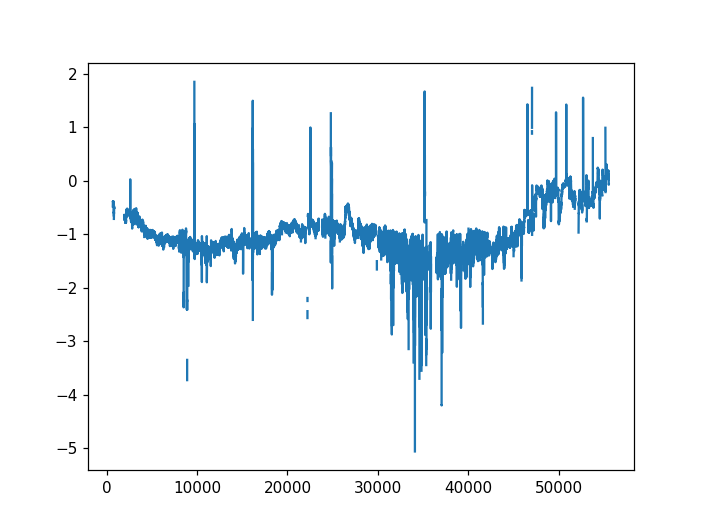

0 1155 1165
1 7055 7080
2 7310 7340
3 7400 7480
4 7605 7610
5 8250 8270
6 8290 8295
7 9075 9100
8 9620 9640
9 13645 13650
10 14690 14745
11 16838 16890
12 20600 20800
13 21080 21125
14 23345 23510
15 30000 30030
16 30090 30140
17 30270 30300
18 31850 31900
19 31960 31970
20 32500 32520
21 32550 32580
22 32650 32675
23 33130 33180
24 33300 33410
25 34400 34600
26 33660 34060
27 35600 35770
28 37700 37780
29 40140 40200
30 44400 44500
31 45110 45120
32 45600 45630
33 48275 48285
34 49400 49420
35 51260 51280
36 52350 52360


<IPython.core.display.Javascript object>


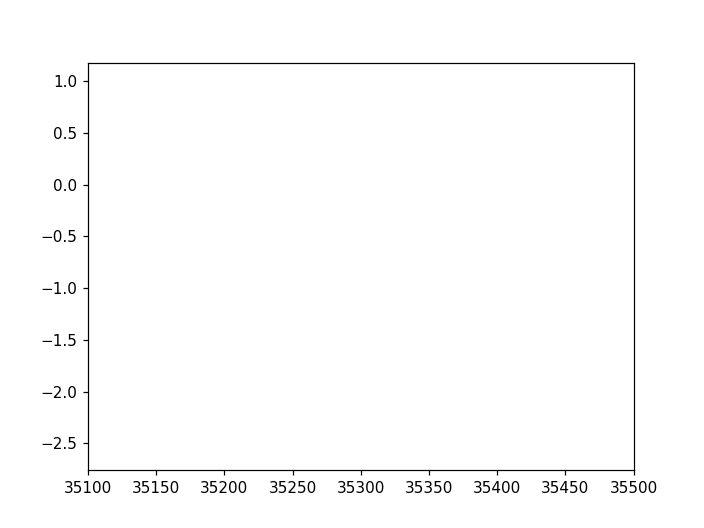

In [49]:
### manually identify (using plot above) noisy parts of the acs_chl timeseries
i2rm = [[1155, 1165], # start and end index of noisy period 1
        [7055, 7080],
        [7310, 7340],
        [7400, 7480],
        [7605, 7610],
        [8250, 8270],
        [8290, 8295],
        [9075, 9100],
        [9620, 9640],
        [13645,13650],
        [14690,14745],
        [16838,16890],
        [20600,20800],
        [21080,21125],
        [23345,23510],  
        [30000,30030],
        [30090,30140],
        [30270,30300],
        [31850,31900],
        [31960,31970],
        [32500,32520],
        [32550,32580],
        [32650,32675],
        [33130,33180],
        [33300,33410],
        [34400,34600],
        [33660,34060],
        [35600,35770],
        [37700,37780],
        [40140,40200],
        [44400,44500],
        [45110,45120],
        [45600,45630],
        [48275,48285],
        [49400,49420],
        [51260,51280],
        [52350,52360]
       ]
    


print(len(i2rm))

plt.plot(np.log10(acs['acs_chl']))
    # set values to nan inside the above intervals
for istart,tmp in enumerate(i2rm):
    print(istart, tmp[0],  tmp[1])
    tmp[0]= tmp[0] +1440
    tmp[1]= tmp[1] +1440
    
    acs['acs_chl'].values[tmp[0]:tmp[1]] = np.nan
    acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs_cp'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs_cp_u'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs_bp'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs_bp_u'].values[tmp[0]:tmp[1], :] = np.nan
    
    acs['acs2_chl'].values[tmp[0]:tmp[1]] = np.nan
    acs['acs2_ap'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs2_ap_u'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs2_cp'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs2_cp_u'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs_bp'].values[tmp[0]:tmp[1], :] = np.nan
    acs['acs_bp_u'].values[tmp[0]:tmp[1], :] = np.nan
    

#
plt.figure()
plt.xlim(35100,35500)
plt.plot(np.log10(acs['acs_chl']))


In [50]:
acs['time'][1440]

<xarray.DataArray 'time' ()>
array('2012-10-14T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2012-10-14
Attributes:
    time zone:  UTC

[ 2880  2881  2882 ... 54717 54718 54719]
[    0     1     2 ... 56157 56158 56159]
[    0     1     2 ... 56157 56158 56159]


<IPython.core.display.Javascript object>


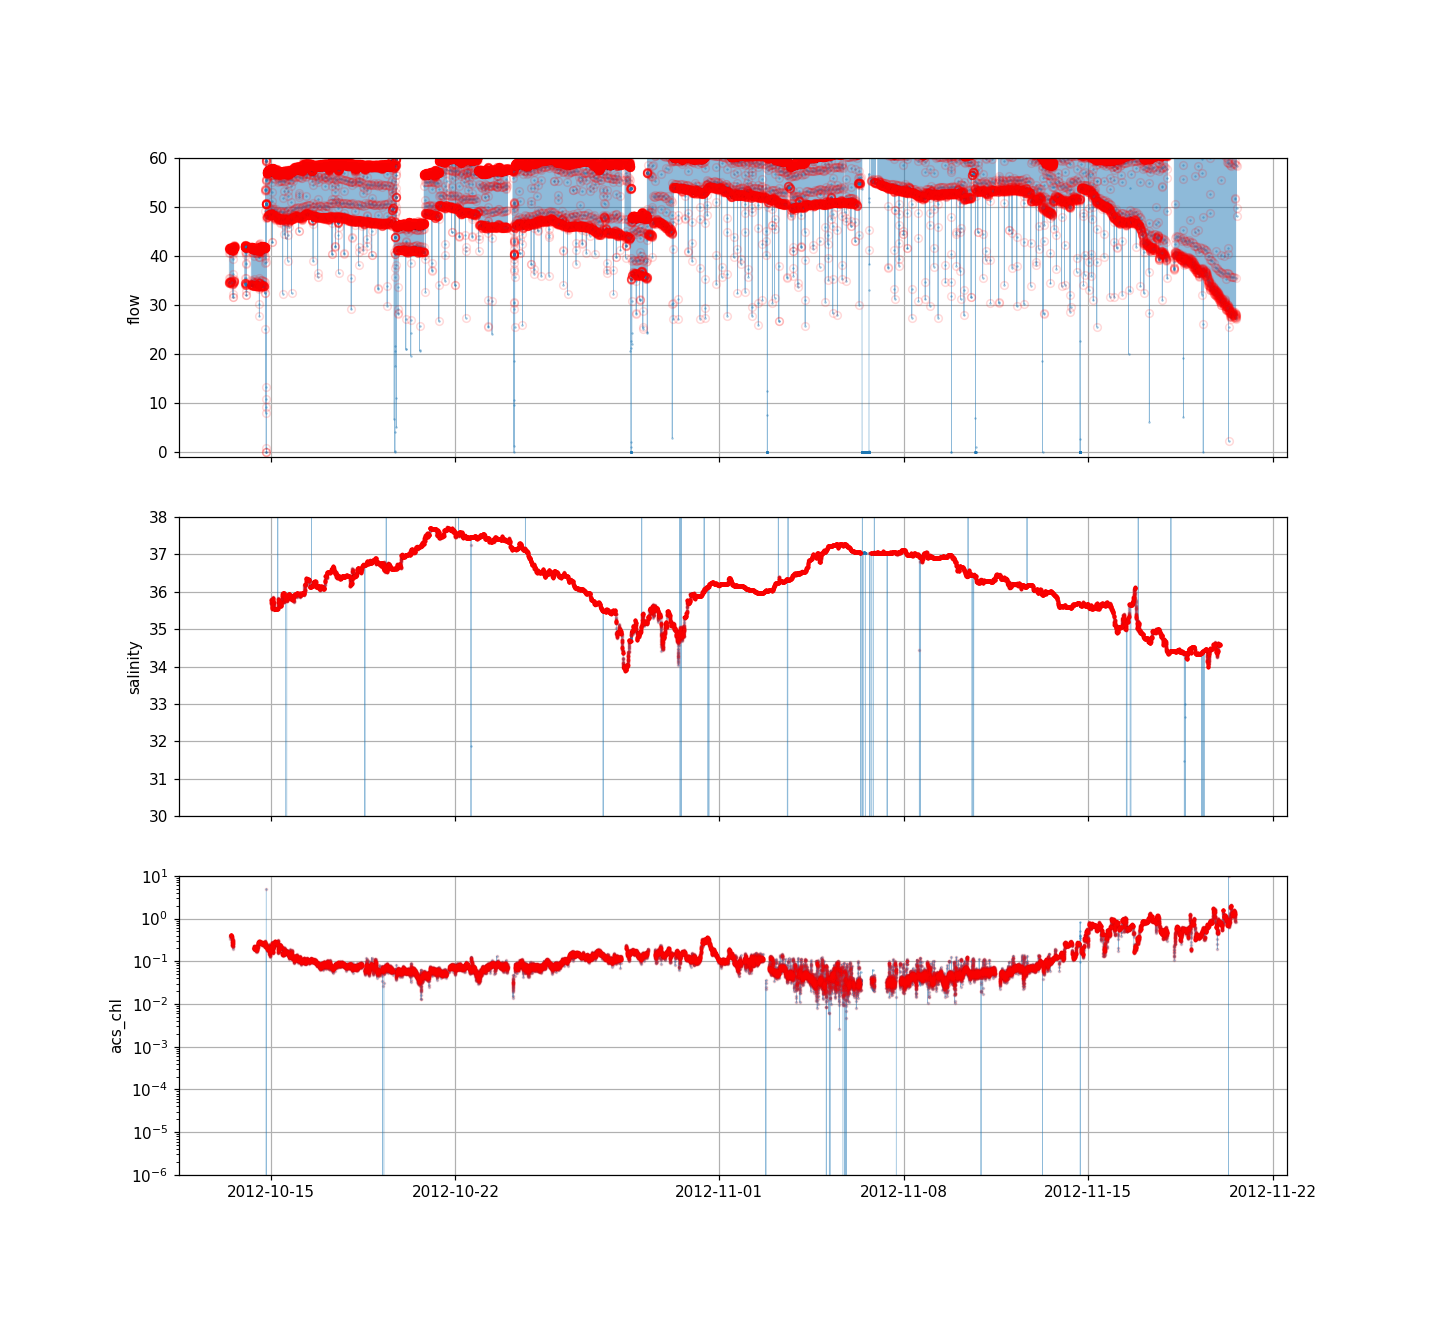

(1e-06, 10)

In [51]:
# filter acs data for MQ and noisy events
MIN_FLOW_RATE = 25
MIN_SAL = 33

i2f1 = np.where((acs.uway_sal>MIN_SAL) & (acs.flow>MIN_FLOW_RATE))[0]  
i2f2 = np.where((np.isnan(acs.uway_sal)==True) | (np.isnan(acs.flow)==True))[0]

i2f = np.union1d(i2f1, i2f2)

print(i2f1)
print(i2f2)
print(i2f)

fig, ax = plt.subplots(3,1, figsize=(13, 12), sharex=True)
ax[0].plot(acs.time, acs.flow, '.-', lw=0.5, ms=1, alpha=0.5)
ax[0].plot(acs.time[i2f], acs.flow[i2f], 'ro', lw=0.5, ms=5, mfc='none', alpha=0.15)
ax[0].set_ylabel('flow')
ax[0].grid('on')
ax[0].set_ylim([-1, 60])


ax[1].plot(acs.time, acs.uway_sal, '.-', lw=0.5, ms=1, alpha=0.5)
ax[1].plot(acs.time[i2f], acs.uway_sal[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[1].set_ylabel('salinity')
ax[1].grid('on')
ax[1].set_ylim([30, 38])

ax[2].semilogy(acs.time, acs.acs_chl, '.-', lw=0.5, ms=1, alpha=0.5)
ax[2].semilogy(acs.time, acs.acs2_chl, '.-', lw=0.5, ms=1, alpha=0.5)
ax[2].semilogy(acs.time[i2f], acs.acs_chl[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[2].semilogy(acs.time[i2f], acs.acs2_chl[i2f], 'r.', lw=0.1, ms=3, mfc='none', alpha=0.15)
ax[2].set_ylabel('acs_chl')
ax[2].grid('on')
plt.ylim([1e-6, 10])

#print(acs.keys())
#print(i2f)
#len(i2f)
#for i in range(len)
 #   print(istart, tmp[0], tmp[1])
  #  acs['acs_chl'].values[tmp[0]:tmp[1]] = np.nan
   # acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
   #acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan
#for istart,tmp in enumerate(i2f):
 #   print(istart, tmp[0], tmp[1])
  #  acs['acs_chl'].values[tmp[0]:tmp[1]] = np.nan
   # acs['acs_ap'].values[tmp[0]:tmp[1], :] = np.nan
   # acs['acs_ap_u'].values[tmp[0]:tmp[1], :] = np.nan


In [52]:
df_hplc.keys()
#df_hplc_surf.keys()
#list(df_hplc['STATION'])
#f_UND = df_hplc_surfloc[(df_hplc_surf['CTD'] == "UND") & (df_hplc_surf['Bottle'] == "UND")]
#df_CTD = f_hplc_surf.loc[(df_hplc_surf['CTD'] != "UND") & (df_hplc_surf['Bottle'] != "UND")]

Index(['GSFC Lab sample code', 'PI', 'Original PI Sample Label', 'Cruise Name',
       'Sequential Sample Number', 'Indicate if filters are replicates',
       'Volume filtered (ml)', 'Station', 'Bottle Number',
       'Sampling Depth (meters)', 'Total Water Depth (meters)',
       'Name of Water Body', 'Water Type',
       'collected with positive pressure or vaccuum', 'Year of Sample',
       'Gregorian Month', 'Day of Gregorian Month', 'Sequential Day of Year',
       'GMT Time', 'Longitude', 'Latitude', 'Filter type',
       'Filter Diameter (mm)', 'Filter storage before shipping to GSFC',
       'date extracted (month/day/year)', 'Vx (ml)', 'Tot_Chl_a', 'Tot_Chl_b',
       'Tot_Chl_c', 'Alpha-beta-Car', 'But-fuco', 'Hex-fuco', 'Allo',
       'Diadino', 'Diato', 'Fuco', 'Perid', 'Zea', 'MV_Chl_a', 'DV_Chl_a',
       'Chlide_a', 'MV_Chl _b', 'DV_Chl_b', 'Chl_c12', 'Chl_c3', 'Lut', 'Neo',
       'Viola', 'Phytin_a', 'Phide_a', 'Pras', 'Gyro', 'TChl', 'PPC', 'PSC',
       'PSP', 'TCar

<IPython.core.display.Javascript object>


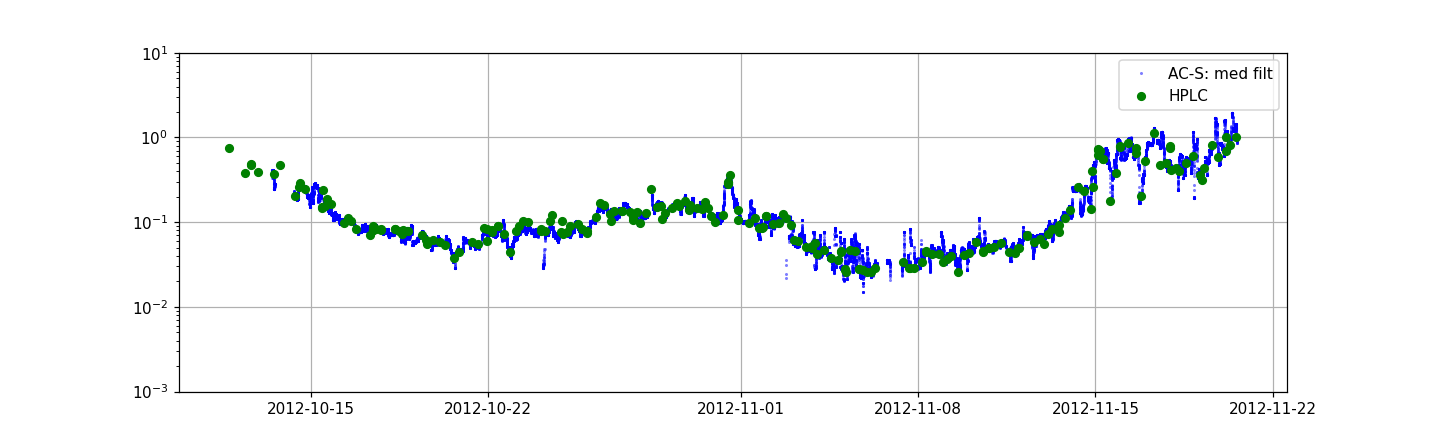

['flow', 'acs_chl', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_cp', 'acs_cp_u', 'acs_N', 'acs2_chl', 'acs2_ap', 'acs2_ap_u', 'acs2_bp', 'acs2_bp_u', 'acs2_cp', 'acs2_cp_u', 'acs2_N', 'ac9_chl', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_cp', 'ac9_cp_u', 'ac9_N', 'bb3_bbp', 'bb3_bbp_err', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp_corr', 'cstar_cp', 'cstar_cp_err', 'uway_lat', 'uway_lon', 'uway_smg', 'uway_cmg', 'uway_heading', 'uway_log', 'uway_uncdepth', 'uway_cordepth', 'uway_sst', 'uway_conductivty', 'uway_sal', 'uway_fluo', 'uway_trans', 'uway_air_temp', 'uway_pressure', 'uway_humidity', 'uway_ptir', 'uway_stir', 'uway_ppar', 'uway_spar', 'uway_wind_speed', 'uway_wind_dir', 'hplc_GSFC_Lab_sample_code', 'hplc_PI', 'hplc_Original_PI_Sample_Label', 'hplc_Cruise_Name', 'hplc_Sequential_Sample_Number', 'hplc_Indicate_if_filters_are_replicates', 'hplc_Volume_filtered_(ml)', 'hplc_Station', 'hplc_Bottle_Number', 'hplc_Sampling_Depth_(meters)', 'hplc_Name_of_Water_Body', 'hplc_Water_

In [53]:
# median filter data
MEDFILT_WIN = 31

innan = np.where(~np.isnan(acs.acs_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges
innan2 = np.where(~np.isnan(acs.acs2_chl[i2f]))[0] # need to remove nans to prevent medfilt to be spiky near edges

fig2, ax2 = plt.subplots(1, figsize=(13, 4))
#ax2.semilogy(acs.time[i2f][innan], acs.acs_chl[i2f][innan], 'r.-', lw=0.1, ms=1, mfc='none')
ax2.semilogy(acs.time[i2f][innan], sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=MEDFILT_WIN), 'bo', lw=1, ms=1, mfc='none', alpha = 0.5, label='AC-S: med filt')
#ax2.semilogy(acs.time[i2f][innan2], acs.acs2_chl[i2f][innan2], 'k.-', lw=0.1, ms=1, mfc='none')
#ax2.semilogy(acs.time[i2f][innan2], sg.medfilt(acs.acs2_chl[i2f][innan2], kernel_size=MEDFILT_WIN), 'bo',color='orange', lw=1, ms=1, mfc='none', alpha = 0.5, label='ACS2: med filt')
ax2.grid('on')
plt.legend()
plt.ylim([1e-3, 10])


print(list(acs.keys()))
ax2.semilogy(acs.hplc_time, acs.hplc_Tot_Chl_a, 'go', ms=5, alpha=1, label='HPLC')#, mfc='none')
#a2.semilogy(df_CTD.index, df_CTD.Tot_Chl_a, 'ko', ms=7, alpha=1, mfc='none', zorder=60)
#ax2.scatter(df_CTD.index, df_CTD.Tot_Chl_a, c=df_CTD.Bottle.values, s=30, alpha=1, zorder=60, cmap = plt.get_cmap('inferno'), vmin=2, vmax=24)
#ax2.semilogy(df_UND.index, df_UND.Tot_Chl_a, 'ks', ms=7, alpha=0.85, mfc='c')
plt.legend()
#########


In [54]:
# compare lat and lon of hplc and acs datasets
#fig, ax = plt.subplots(2, 1, figsize = (14, 8), sharex = True)

#ax[0].plot(acs.time, acs.uway_lat, '.', ms = 1, mfc = 'none')
##ax[0].plot(acs.hplc_time, acs.hplc_lat, 'ro', ms = 4, mfc = 'none', alpha = 0.5)
#ax[0].set_ylabel("latitude")
#ax[1].plot(acs.time, acs.uway_lon, '.', ms = 1, mfc = 'none')
#ax[1].plot(acs.hplc_time, acs.hplc_lon, 'ro', ms = 4, mfc = 'none', alpha = 0.5)
#ax[1].set_ylabel("longitude")
df_hplc_surf.keys()

Index(['GSFC Lab sample code', 'PI', 'Original PI Sample Label', 'Cruise Name',
       'Sequential Sample Number', 'Indicate if filters are replicates',
       'Volume filtered (ml)', 'Station', 'Bottle Number',
       'Sampling Depth (meters)', 'Name of Water Body', 'Water Type',
       'collected with positive pressure or vaccuum', 'Year of Sample',
       'Gregorian Month', 'Day of Gregorian Month', 'Sequential Day of Year',
       'lon', 'lat', 'Filter type', 'Filter Diameter (mm)',
       'Filter storage before shipping to GSFC',
       'date extracted (month/day/year)', 'Vx (ml)', 'Tot_Chl_a', 'Tot_Chl_b',
       'Tot_Chl_c', 'Alpha-beta-Car', 'But-fuco', 'Hex-fuco', 'Allo',
       'Diadino', 'Diato', 'Fuco', 'Perid', 'Zea', 'MV_Chl_a', 'DV_Chl_a',
       'Chlide_a', 'MV_Chl _b', 'DV_Chl_b', 'Chl_c12', 'Chl_c3', 'Lut', 'Neo',
       'Viola', 'Phytin_a', 'Phide_a', 'Pras', 'Gyro', 'TChl', 'PPC', 'PSC',
       'PSP', 'TCaro', 'TAcc', 'TPg', 'DP', 'comments', 'time'],
      dtype='o

In [55]:
#####################################################################################
# creat lat-lon coordianets for hplc data - first need to interpolate to the u_way

 # note - IN GENERAL THIS IS NOT NEEDED
    
#ds_hplc_surf = pd.Series(df_hplc_surf.Tot_Chl_a.values, index = df_hplc_surf.index)
#ds_hplc_surf = ds_hplc_surf.groupby('time').mean() # note - time field sometimes called date?

# averages duplicate values

#df_lat = pd.Series(acs.uway_lat, index = acs.time.values)
#df_lon = pd.Series(acs.uway_lon, index = acs.time.values)
#
#df_hplc_coords = pd.DataFrame({'Tot_Chl_a': ds_hplc_surf, 'hplc_lat': df_lat, 'hplc_long': df_lon })


#df_hplc_coords = df_hplc_coords.interpolate().reindex(ds_hplc_surf.index)


#_attrs = {}
#_var = (['hplc_time'],df_hplc_coords['hplc_lat']) 
#acs['hplc_lat'] = _var
#acs['hplc_lat'].attrs = _attrs

#_attrs = {}                                                                    
#_var = (['hplc_time'],df_hplc_coords['hplc_lon']) 
#acs['hplc_lon'] = _var
#acs['hplc_lon'].attrs = _attrs

In [56]:
sorted(acs.keys())

['ac9_N',
 'ac9_ap',
 'ac9_ap_u',
 'ac9_bp',
 'ac9_bp_u',
 'ac9_chl',
 'ac9_cp',
 'ac9_cp_u',
 'acs2_N',
 'acs2_ap',
 'acs2_ap_u',
 'acs2_bp',
 'acs2_bp_u',
 'acs2_chl',
 'acs2_cp',
 'acs2_cp_u',
 'acs_N',
 'acs_ap',
 'acs_ap_u',
 'acs_bp',
 'acs_bp_u',
 'acs_chl',
 'acs_cp',
 'acs_cp_u',
 'bb3_bb02',
 'bb3_bb02_err',
 'bb3_bbp',
 'bb3_bbp_corr',
 'bb3_bbp_err',
 'cstar_cp',
 'cstar_cp_err',
 'flow',
 'hplc_Allo',
 'hplc_Alpha-beta-Car',
 'hplc_Bottle_Number',
 'hplc_But-fuco',
 'hplc_Chl_c12',
 'hplc_Chl_c3',
 'hplc_Chlide_a',
 'hplc_Cruise_Name',
 'hplc_DP',
 'hplc_DV_Chl_a',
 'hplc_DV_Chl_b',
 'hplc_Day_of_Gregorian_Month',
 'hplc_Diadino',
 'hplc_Diato',
 'hplc_Filter_Diameter_(mm)',
 'hplc_Filter_storage_before_shipping_to_GSFC',
 'hplc_Filter_type',
 'hplc_Fuco',
 'hplc_GSFC_Lab_sample_code',
 'hplc_Gregorian_Month',
 'hplc_Gyro',
 'hplc_Hex-fuco',
 'hplc_Indicate_if_filters_are_replicates',
 'hplc_Lut',
 'hplc_MV_Chl_a',
 'hplc_MV_Chl_b',
 'hplc_Name_of_Water_Body',
 'hplc_Neo',

In [57]:
# df_CTD.keys()
# print(df_hplc_acs)
#df_hplc_combined['Tot_Chl_a'][0:14]= df_hplc_acs['Tot_Chl_a'][0:14]

print(df_hplc_surf.keys())

Index(['GSFC Lab sample code', 'PI', 'Original PI Sample Label', 'Cruise Name',
       'Sequential Sample Number', 'Indicate if filters are replicates',
       'Volume filtered (ml)', 'Station', 'Bottle Number',
       'Sampling Depth (meters)', 'Name of Water Body', 'Water Type',
       'collected with positive pressure or vaccuum', 'Year of Sample',
       'Gregorian Month', 'Day of Gregorian Month', 'Sequential Day of Year',
       'lon', 'lat', 'Filter type', 'Filter Diameter (mm)',
       'Filter storage before shipping to GSFC',
       'date extracted (month/day/year)', 'Vx (ml)', 'Tot_Chl_a', 'Tot_Chl_b',
       'Tot_Chl_c', 'Alpha-beta-Car', 'But-fuco', 'Hex-fuco', 'Allo',
       'Diadino', 'Diato', 'Fuco', 'Perid', 'Zea', 'MV_Chl_a', 'DV_Chl_a',
       'Chlide_a', 'MV_Chl _b', 'DV_Chl_b', 'Chl_c12', 'Chl_c3', 'Lut', 'Neo',
       'Viola', 'Phytin_a', 'Phide_a', 'Pras', 'Gyro', 'TChl', 'PPC', 'PSC',
       'PSP', 'TCaro', 'TAcc', 'TPg', 'DP', 'comments', 'time'],
      dtype='o

<IPython.core.display.Javascript object>


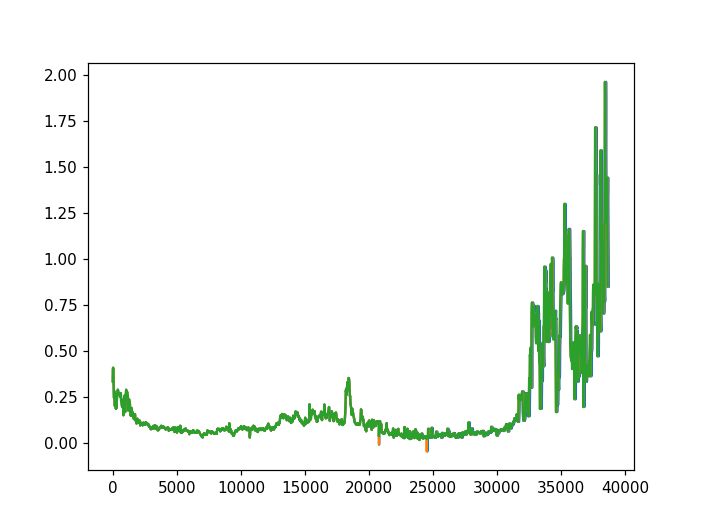

In [58]:

#df_hplc_surf = df_hplc_surf
# merge HPCL and ACS data
# see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate
# here made with dataframe instead of series

# averages duplicate values
#df_hplc_surf = df_hplc_surf.groupby('time').mean() 


#step x - # filters w.r.t. i2fn (mQ interval + previous manual spike removal) and innan
plt.figure()
ix = xr.DataArray(acs.time[i2f][innan], dims=['time']) 
acs_filtered_x = acs.sel(time = ix)
acs_filtered_x['acs_chl'].values = sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31) # apply med filter to acx chl and acx chl debiasesd 
plt.plot(acs_filtered_x['acs_chl'].values)


#step y - # filters w.r.t. ap (10the element) being > 0
i2kp = np.where((acs_filtered_x.acs_ap[:,10] > 0)) [0]
iy = xr.DataArray(acs_filtered_x.time[i2kp], dims=['time']) 
acs_filtered_xy = acs_filtered_x.sel(time = iy)
plt.plot(acs_filtered_xy['acs_chl'].values)

#step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs_filtered_xy.acs_chl[:] > 0)) [0]
iz = xr.DataArray(acs_filtered_xy.time[i2kp], dims=['time']) 
acs_filtered_xyz = acs_filtered_xy.sel(time = iz)
plt.plot(acs_filtered_xyz['acs_chl'].values)


#step zb - # filters w.r.t. lat anomolies
i2kp = np.where((acs_filtered_xyz.uway_lat[:] < 100)) [0]
iz_temp = xr.DataArray(acs_filtered_xyz.time[i2kp], dims=['time']) 
acs_filtered_xyz_temp = acs_filtered_xyz.sel(time = iz_temp)

acs_filtered_xyz = acs_filtered_xyz_temp


# create pandas series with medfilt ACS data
#df_acs = pd.Series(acs_filtered_xyz['acs_chl'].values,index = acs_filtered_xyz.time.values)
#df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc_surf.Tot_Chl_a, 'acs_chl': df_acs})
#df_hplc_acs = df_hplc_acs.interpolate('index',limit=1).reindex(df_hplc_surf.index,method='nearest',tolerance='30min')
# merge HPCL and ACS data
# see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate
# here made with dataframe instead of series


In [59]:


# create pandas series with medfilt ACS data
df_hplc_surf = df_hplc_surf.groupby('time').mean() 


df_acs = pd.Series(acs_filtered_xyz['acs_chl'].values,index = acs_filtered_xyz.time.values)
df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc_surf.Tot_Chl_a, 'acs_chl': df_acs})
df_hplc_acs = df_hplc_acs.interpolate('index',limit=1).reindex(df_hplc_surf.index,method='nearest',tolerance='30min')
# merge HPCL and ACS data
# see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate
# here made with dataframe instead of series


/tmp/ipykernel_305230/2328967504.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_hplc_surf = df_hplc_surf.groupby('time').mean()


In [60]:
# merge HPLC and ACS data
# see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate
########################################################################################################################

#df_hplc_surf_new = df_hplc_surf
# merge HPCL and ACS data
# see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate
# here made with dataframe instead of series

# averages duplicate values THIS  ACCOUNTS FOR REPLICATES (IF PRESENT)
#df_hplc_surf_new = df_hplc_surf_new.groupby('time').mean() 

# create pandas series with medfilt ACS data
#df_acs = pd.Series(sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])

#df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc_surf_new.Tot_Chl_a, 'acs_chl': df_acs})

#df_hplc_acs = df_hplc_acs.interpolate('index').reindex(df_hplc_surf_new.index)




print(df_hplc_acs)
    

                     Tot_Chl_a   acs_chl
time                                    
2012-10-11 18:25:00     0.7570       NaN
2012-10-12 09:28:00     0.3800       NaN
2012-10-12 15:21:00     0.4785       NaN
2012-10-12 21:20:00     0.3960       NaN
2012-10-13 13:22:00     0.3710       NaN
...                        ...       ...
2012-11-19 20:35:00     0.5860  0.648094
2012-11-20 03:40:00     1.0040  0.786686
2012-11-20 04:06:00     0.6840       NaN
2012-11-20 07:18:00     0.8070       NaN
2012-11-20 13:47:00     1.0180       NaN

[195 rows x 2 columns]


In [61]:
#df_hplc_surf_new = df_hplc_surf
# merge HPCL and ACS data
# see https://stackoverflow.com/questions/26517125/combine-two-pandas-dataframes-resample-on-one-time-column-interpolate
# here made with dataframe instead of series

# averages duplicate values
#df_hplc_surf_new = df_hplc_surf_new.groupby('time').mean() 

# create pandas series with medfilt ACS data
#df_acs = pd.Series(sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31), index = acs.time.values[i2f][innan])
#df_hplc_acs = pd.DataFrame({'Tot_Chl_a': df_hplc_surf_new.Tot_Chl_a, 'acs_chl': df_acs})
#df_hplc_acs = df_hplc_acs.interpolate('index').reindex(df_hplc_surf_new.index)
    


In [62]:
# compute residuals and stats (lin and log space)
rres = df_hplc_acs.acs_chl.values / df_hplc_acs.Tot_Chl_a.values - 1

rres_log = np.log10(df_hplc_acs.acs_chl.values) / np.log10(df_hplc_acs.Tot_Chl_a.values) - 1

delta = np.nanmedian(rres)
delta_log = np.nanmedian(rres_log)
sigma = prcrng(rres)
sigma_log = prcrng(rres_log)
N = np.sum(~np.isnan(rres))

print(delta, sigma, N)

print(delta_log, sigma_log, N)

0.019664956503881448 0.13216227895607666 182
-0.009503143526679636 0.06734658959160902 182


In [63]:

print(rres)

[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan  0.00624916 -0.37185172
  0.04060561 -0.21729109 -0.06862618 -0.02151936 -0.09097886 -0.0137
  0.04028788 -0.03505048  0.02097968 -0.08651579  0.10540971  0.03887409
 -0.05159018 -0.10087549 -0.10180421  0.0348646   0.04092471  0.11354395
  0.04649392  0.10933678  0.00431001 -0.01324449  0.1813716  -0.02521461
  0.10577503  0.02536796 -0.05249775 -0.12422021  0.18405207 -0.15537419
 -0.08435719 -0.07536675 -0.00569817 -0.08062088 -0.19514783 -0.20051789
 -0.16863412 -0.16084454 -0.42861456 -0.13803191 -0.12790358 -0.27182764
 -0.04315422 -0.29787568 -0.02644952  0.02969755 -0.26133321 -0.0616837
 -0.12808424 -0.02441292 -0.07775559 -0.09146118 -0.05660321  0.01835023
  0.31510271 -0.05513876 -0.02701862  0.04112134  0.03834106 -0.16687965
  0.02204409 -0.08475454 -0.21595807  0.10685307  0.10863776  0.36317325
 -0.00815805  0.02209522  0.0028319  -0.05089921 -0.0020

<IPython.core.display.Javascript object>


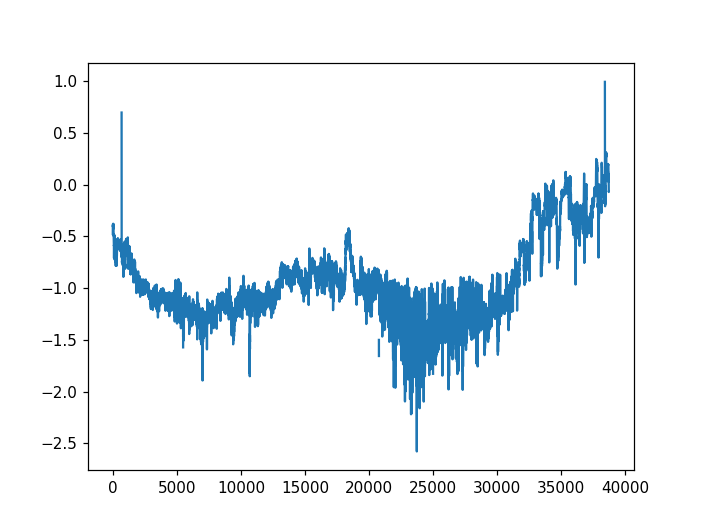

/local1/data/scratch/rsg/tjor/anaconda3/envs/monocle_test_hsp/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


In [64]:
plt.figure()
plt.plot(np.log10(acs.acs_chl[i2f][innan]))



<IPython.core.display.Javascript object>


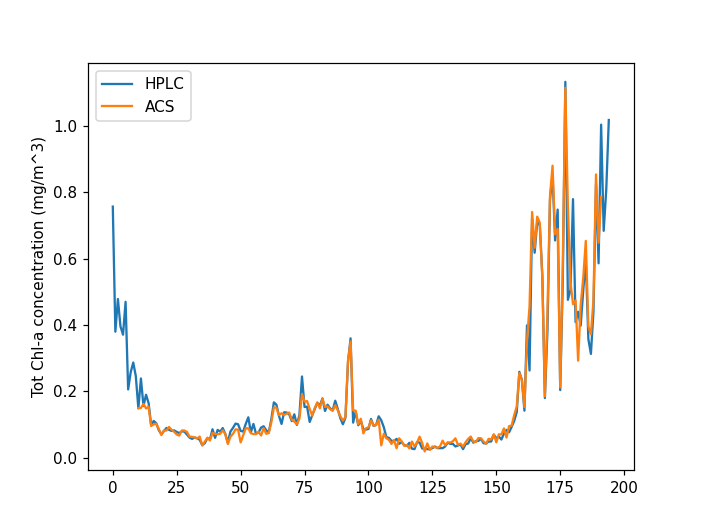

<xarray.DataArray 'time' (time: 56160)>
array(['2012-10-13T00:00:00.000000000', '2012-10-13T00:00:59.999996416',
       '2012-10-13T00:02:00.000002816', ..., '2012-11-20T23:57:00.000000768',
       '2012-11-20T23:57:59.999997184', '2012-11-20T23:59:00.000003584'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2012-10-13 ... 2012-11-20T23:59:00.000003584
Attributes:
    time zone:  UTC

In [65]:
plt.figure()
plt.plot(df_hplc_acs.Tot_Chl_a.values,label='HPLC')
plt.plot(df_hplc_acs.acs_chl.values,label='ACS')
plt.ylabel('Tot Chl-a concentration (mg/m^3)')
#plt.xlabel('Sample index')
plt.legend()

acs.time



<IPython.core.display.Javascript object>


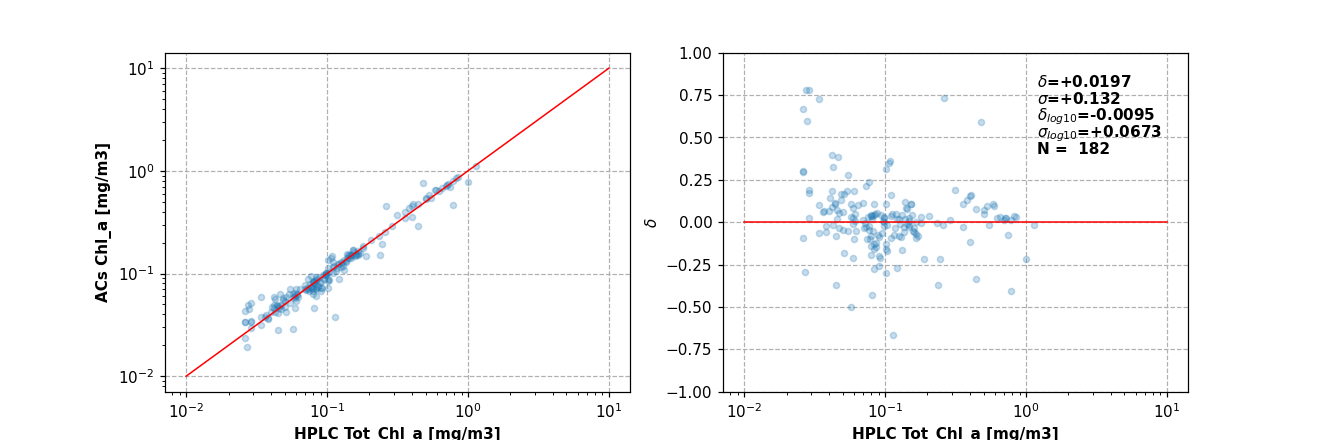

[0.757      0.38       0.4785     0.396      0.371      0.47
 0.206      0.258      0.287      0.246      0.149      0.239
 0.156      0.19       0.165      0.098      0.111      0.104
 0.083      0.071      0.08033333 0.09       0.084      0.081
 0.0825     0.078      0.0745     0.0795     0.079      0.07
 0.061      0.057      0.061      0.059      0.054      0.038
 0.044      0.059      0.055      0.086      0.06       0.084
 0.079      0.0895     0.072      0.045      0.079      0.09
 0.103      0.101      0.081      0.079      0.102      0.122
 0.077      0.102      0.073      0.076      0.091      0.095
 0.083      0.0765     0.116      0.167      0.16       0.126
 0.102      0.137      0.1365     0.131      0.1105     0.131
 0.099      0.129      0.245      0.153      0.154      0.108
 0.128      0.147      0.166      0.157      0.179      0.141
 0.16       0.149      0.143      0.172      0.147      0.119
 0.101      0.121      0.289      0.36       0.106      0.139
 0.098     

In [66]:


fig, ax = plt.subplots(1,2, figsize=(12, 4))

ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl.values, 'o', ms=4, alpha=0.25)
x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('$\delta$', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(1.2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.7, r'$\sigma$='+f'{sigma:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.6, r'$\delta_{log10}$='+f'{delta_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.5, r'$\sigma_{log10}$='+f'{sigma_log:+0.3}', fontweight='bold')
ax[1].text(1.2, 0.4, f'N = {N: 0}', fontweight='bold')




print(df_hplc_acs.Tot_Chl_a.values)



<IPython.core.display.Javascript object>


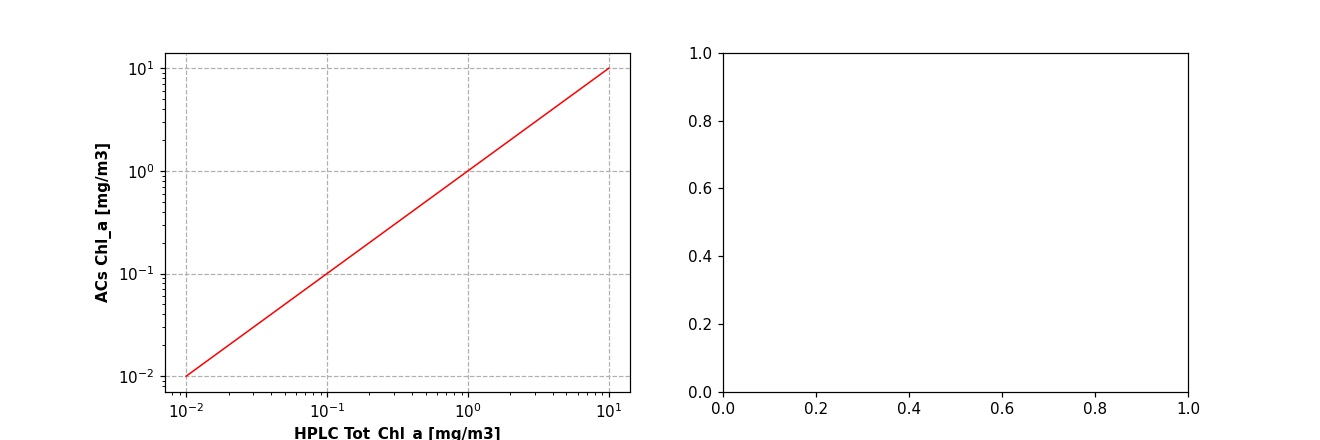

NameError: name 'Tot_chl_combined' is not defined

In [67]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
#
#ax[0].loglog(Tot_chl_combined, acs_combined, 'o', ms=4, alpha=0.25)
#x = np.logspace(np.log10(0.01), np.log10(10), 100)
ax[0].loglog(x, x, 'r-', lw=1)
ax[0].grid('on', ls='--')
ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[0].set_ylabel('ACs Chl_a [mg/m3]', fontweight='bold')

ax[1].semilogx(Tot_chl_combined, rres3, 'o', ms=4, alpha=0.25)
ax[1].semilogx(x, x*0, 'r-', lw=1)
ax[1].grid('on', ls='--')
ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
ax[1].set_ylabel('ACHPLC [-]', fontweight='bold')
ax[1].set_ylim([-1, 1])
ax[1].text(2, 0.8, r'$\delta$='+f'{delta3:+0.3}', fontweight='bold')
ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma3: 0.3}', fontweight='bold')
ax[1].text(2, 0.6, f'N = {N3: 0}', fontweight='bold')



<IPython.core.display.Javascript object>


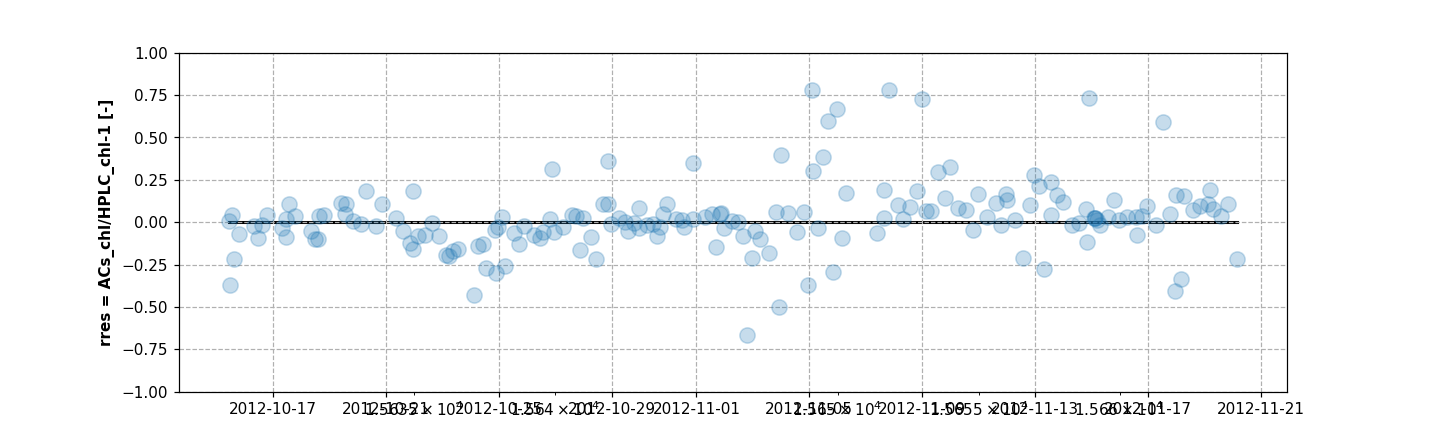

(-1.0, 1.0)

In [68]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.semilogx(df_hplc_acs.index.values, rres, 'o', ms=10, alpha=0.25, zorder=60)
ax.plot(df_hplc_acs.index.values, rres*0, 'k-', lw=2, zorder=1)
ax.set_ylabel('rres = ACs_chl/HPLC_chl-1 [-]', fontweight='bold')
ax.grid('on', ls='--')
ax.set_ylim([-1, 1])

In [69]:
#ilrg_rres = np.where(abs(rres)>0.5)[0]
#print(rres[ilrg_rres])
#df_hplc_surf_new.iloc[ilrg_rres]

In [70]:
#df_hplc_surf_new.iloc[ilrg_rres].index.dayofyear
# tt.tm_yday

In [71]:
#df_hplc_surf_new.iloc[ilrg_rres].keys()

In [72]:
# find dates of large rres
r = df_hplc_acs.acs_chl / df_hplc_acs.Tot_Chl_a - 1
ii = np.where(abs(r)>0.4)[0]
print(r[ii])
# iss = 2
# [df_hplc_acs.Tot_Chl_a[ii][iss], df_hplc_acs.acx_chl[ii][iss]]

time
2012-10-24 02:40:00   -0.428615
2012-11-02 18:42:00   -0.668037
2012-11-03 22:09:00   -0.499292
2012-11-05 02:09:00    0.777472
2012-11-05 15:52:00    0.594694
2012-11-05 23:47:00    0.665929
2012-11-07 19:43:00    0.780763
2012-11-08 23:40:00    0.726664
2012-11-14 22:03:00    0.735093
2012-11-17 13:23:00    0.590485
2012-11-17 23:04:00   -0.406104
dtype: float64


In [73]:
# # de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
# df_hplc_acs.acs_chl_debiased = df_hplc_acs.acs_chl*(1-delta)

In [74]:
# # compute resuduals and stats
# rres = df_hplc_acs.acs_chl_debiased.values/df_hplc_acs.Tot_Chl_a.values-1

# delta = np.nanmedian(rres)
# sigma = prcrng(rres)
# N = len(rres)

# print(delta, sigma, N)

In [75]:
# fit data to power law -- not useD?
from scipy.optimize import curve_fit

def func(x, a, b):
    return a * x**b

print(df_hplc_acs.acs_chl.values[np.isnan(df_hplc_acs.acs_chl)==0])

popt, pcov = curve_fit(func, 0.014*df_hplc_acs.acs_chl.values[np.isnan(df_hplc_acs.acs_chl)==0] , df_hplc_acs.Tot_Chl_a.values[np.isnan(df_hplc_acs.acs_chl)==0])

perr = np.sqrt(np.diag(pcov)) # parameter uncertainty 

print("chl_HPLC = a * chl_ACS^b " )

print("a = " + f'{popt[0]:.1f} ' + "+/- " + f'{perr[0]:.1f}' )
print("b = " + f'{popt[1]:.3f} ' + "+/- " + f'{perr[1]:.3f}' )


[0.14993113 0.15012744 0.16233448 0.14871469 0.15367668 0.0958911
 0.10090135 0.1025752  0.08634389 0.06851142 0.0820187  0.08221358
 0.09285442 0.0841488  0.07824381 0.07013171 0.06691559 0.08227174
 0.08223305 0.07794808 0.06383613 0.0632322  0.06126291 0.05821858
 0.06379407 0.03704185 0.0486541  0.06049671 0.05211262 0.07531706
 0.07104312 0.07094857 0.07233578 0.08275468 0.07158973 0.04137206
 0.06358332 0.07195339 0.08563069 0.0847547  0.04628222 0.06809548
 0.08895383 0.08883703 0.07367713 0.07161668 0.07106918 0.07825701
 0.06721868 0.08914005 0.07236901 0.07463241 0.10698035 0.15172598
 0.15094349 0.12831213 0.13414048 0.12944599 0.13281196 0.1363869
 0.11473669 0.10913877 0.10118236 0.11806666 0.19209027 0.16934852
 0.17073021 0.14722271 0.12695577 0.150248   0.1664701  0.14900882
 0.17864195 0.15294299 0.15491149 0.14658066 0.14147252 0.15834895
 0.14319702 0.12504705 0.11197453 0.12321579 0.29245649 0.35058054
 0.14303329 0.141938   0.10117064 0.1176096  0.07348734 0.088936

In [76]:
# as previous but apply log transform prior to fitting
import scipy

linear_mod = scipy.stats.linregress(np.log10(0.014*df_hplc_acs.acs_chl.values[np.isnan(df_hplc_acs.acs_chl)==0]), np.log10(df_hplc_acs.Tot_Chl_a.values[np.isnan(df_hplc_acs.acs_chl)==0]))


A = np.round(100*linear_mod.intercept)/100
B = np.round(1000*linear_mod.slope)/1000
r_sq = np.round(1000*linear_mod.rvalue**2)/100

r_sq = np.round(1000*linear_mod.rvalue**2)/1000
stderr = np.round(1000*linear_mod.stderr)/1000
interr = np.round(1000*linear_mod.intercept_stderr)/1000


print('A = ' + str(10**A) + ' +/- ' + str(2*10**interr))
print('B = ' + str(B) + ' +/- ' + str(2*stderr))

print(r_sq)


A = 63.09573444801933 +/- 2.238875766934303
B = 0.982 +/- 0.034
0.947


In [77]:
# fig, ax = plt.subplots(1,2, figsize=(10, 4))

# ax[0].loglog(df_hplc_acs.Tot_Chl_a.values, df_hplc_acs.acs_chl_debiased.values, 'o', ms=4, alpha=0.25)
# x = np.logspace(np.log10(0.01), np.log10(10), 100)
# ax[0].loglog(x, x, 'r-', lw=1)
# ax[0].grid('on', ls='--')
# ax[0].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
# ax[0].set_ylabel('ACS Chl_a [mg/m3]', fontweight='bold')

# ax[1].semilogx(df_hplc_acs.Tot_Chl_a.values, rres, 'o', ms=4, alpha=0.25)
# ax[1].semilogx(x, x*0, 'r-', lw=1)
# ax[1].grid('on', ls='--')
# ax[1].set_xlabel('HPLC Tot_Chl_a [mg/m3]', fontweight='bold')
# ax[1].set_ylabel('ACS/HPLC-1 [-]', fontweight='bold')

# ax[1].text(2, 0.8, r'$\delta$='+f'{delta:+0.3}', fontweight='bold')
# ax[1].text(2, 0.7, r'$\sigma$='+f'{sigma: 0.3}', fontweight='bold')
# ax[1].text(2, 0.6, f'N = {N: 0}', fontweight='bold')


In [78]:
# de-bias ACS-chl following eq 3 in Graban et al., 2020 (https://doi.org/10.1364/OE.397863)
innan = np.where(~np.isnan(acs.acs_chl[i2f]))[0]
acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
# acs['acs_chl_debiased'] = acs.acs_chl*(1-delta)
acs_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan],
                               'lon [degE]': acs.uway_lon[i2f][innan],
                               'acs_chl_debiased [mg_m3]': acs.acs_chl_debiased[i2f][innan]
                              }  ,
                      index = acs.time.values[i2f][innan])


# de-bias ACS-2 
#innan2 = np.where(~np.isnan(acs.acs2_chl[i2f]))[0]
#acs['acs2_chl_debiased'] = acs.acs2_chl*(1-delta) 
#acs2_out = pd.DataFrame(data = {'lat [degN]': acs.uway_lat[i2f][innan2],
           #                    'lon [degE]': acs.uway_lon[i2f][innan2],
    #                           'acs2_chl_debiased [mg_m3]': acs.acs2_chl_debiased[i2f][innan2]
                 #             }  )
                    #  index = acs.time.values[i2f][innan])
# acs_out.index.rename('date_time [UTC]', inplace = True)
#acs_out.index.rename('date_time [UTC]', inplace = True)
#acs2_out.index.rename('date_time [UTC]', inplace = True)

In [79]:
# add attributes to acs_chl_debiased
acs.acs_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
acs.acs_chl_debiased.attrs["delta"] = delta
acs.acs_chl_debiased.attrs["sigma"] = sigma
acs.acs_chl_debiased.attrs["units"] = "mg/m3"
acs.acs_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
acs.acs_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs.Tot_Chl_a.values
acs.acs_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["acs_chl"] = df_hplc_acs.acs_chl.values
acs.acs_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
acs.acs_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
acs.acs_chl_debiased.attrs["match_up_dates"] = df_hplc_acs.index.format()


#acs.acs2_chl_debiased.attrs["debiasing_equation"] = "acs.acs_chl_debiased = acs.acs_chl*(1-delta)"
#acs.acs2_chl_debiased.attrs["delta"] = delta2
#acs.acs2_chl_debiased.attrs["sigma"] = sigma2
#acs.acs2_chl_debiased.attrs["units"] = "mg/m3"
#acs.acs2_chl_debiased.attrs["comments"] = "delta=np.nanmedian(rres), sigma=prcrng(rres), rres=acs_chl/HPLC_Tot_Chl_a-1, based on surface data"
#acs.acs2_chl_debiased.attrs["HPLC_Tot_chla"] = df_hplc_acs2.Tot_Chl_a.values
#acs.acs2_chl_debiased.attrs["HPLC_Tot_chla_units"] = "mg/m3"
#acs.acs2_chl_debiased.attrs["acs_chl"] = df_hplc_acs2.acs2_chl.values
#acs.acs2_chl_debiased.attrs["acs_chl_units"] = "mg/m3"
#acs.acs2_chl_debiased.attrs["processed_on"] = dt.now().strftime("%Y-%m-%d %H:%M:%S.%f")
#acs.acs2_chl_debiased.attrs["match_up_dates"] = df_hplc_acs2.index.format()



<IPython.core.display.Javascript object>


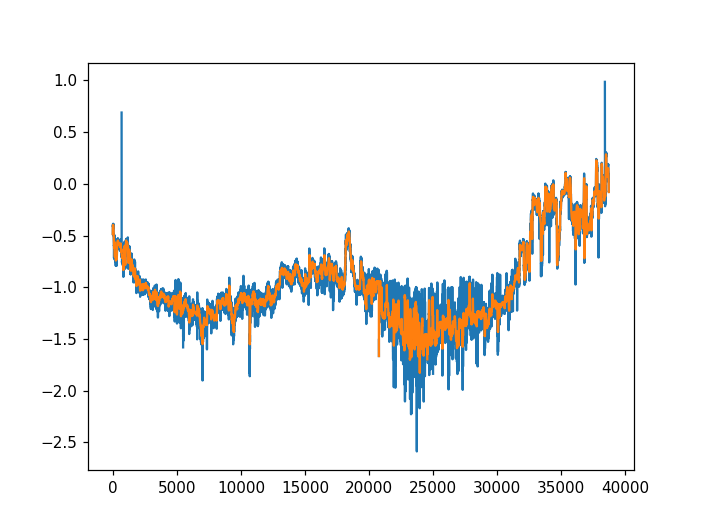

/tmp/ipykernel_305230/1451806263.py:3: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(acs['acs_chl_debiased'].values[i2f][innan]))
/tmp/ipykernel_305230/1451806263.py:10: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(acs_filtered_x['acs_chl_debiased'].values))


In [80]:

#step x - # filters w.r.t. i2fn (mQ interval + previous manual spike removal) and innan
plt.figure()
plt.plot(np.log10(acs['acs_chl_debiased'].values[i2f][innan]))
ix = xr.DataArray(acs.time[i2f][innan], dims=['time']) 
acs_filtered_x = acs.sel(time = ix)
acs_filtered_x['acs_chl_nomedfilt'] = acs.acs_chl[i2f][innan] # save non-filtered data
acs_filtered_x['acs_chl_debiased_nomedfilt'] = acs.acs_chl_debiased[i2f][innan]
acs_filtered_x['acs_chl'].values = sg.medfilt(acs.acs_chl[i2f][innan], kernel_size=31) # apply med filter to acx chl and acx chl debiasesd 
acs_filtered_x['acs_chl_debiased'].values = sg.medfilt(acs.acs_chl_debiased[i2f][innan], kernel_size=31)
plt.plot(np.log10(acs_filtered_x['acs_chl_debiased'].values))

#step y - # filters w.r.t. ap (10the element) being > 0
i2kp = np.where((acs_filtered_x.acs_ap[:,10] > 0)) [0]
iy = xr.DataArray(acs_filtered_x.time[i2kp], dims=['time']) 
acs_filtered_xy = acs_filtered_x.sel(time = iy)

#step z - # filters w.r.t. acs chl being > 0
i2kp = np.where((acs_filtered_xy.acs_chl[:] > 0)) [0]
iz = xr.DataArray(acs_filtered_xy.time[i2kp], dims=['time']) 
acs_filtered_xyz = acs_filtered_xy.sel(time = iz)

#step zb - # filters w.r.t. lat anomolies
i2kp = np.where((acs_filtered_xyz.uway_lat[:] < 100)) [0]
iz_temp = xr.DataArray(acs_filtered_xyz.time[i2kp], dims=['time']) 
acs_filtered_xyz_temp = acs_filtered_xyz.sel(time = iz_temp)

acs_filtered_xyz = acs_filtered_xyz_temp
#plt.figure()
#plt.plot(acs_filtered_xyz['uway_lat'],np.log10(acs_filtered_xyz['acs_chl_debiased'].values),color='red')
#plt.plot(acs_filtered_x['uway_lat'],np.log10(acs_filtered_x['acs_chl_debiased'].values), color='pink')



<IPython.core.display.Javascript object>


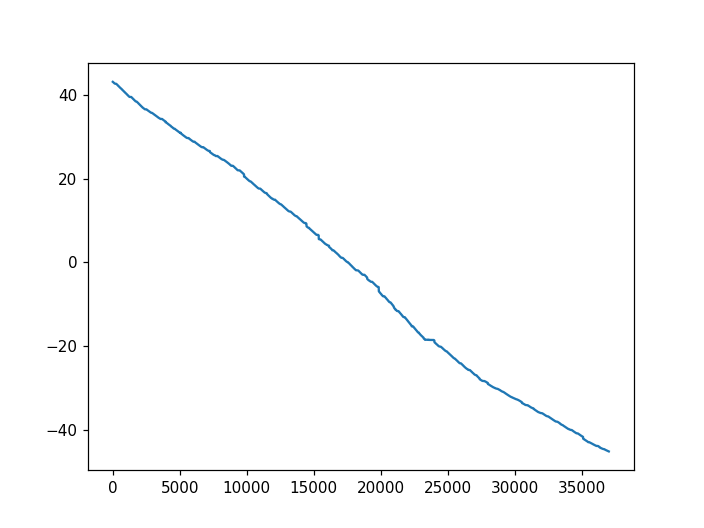

<IPython.core.display.Javascript object>


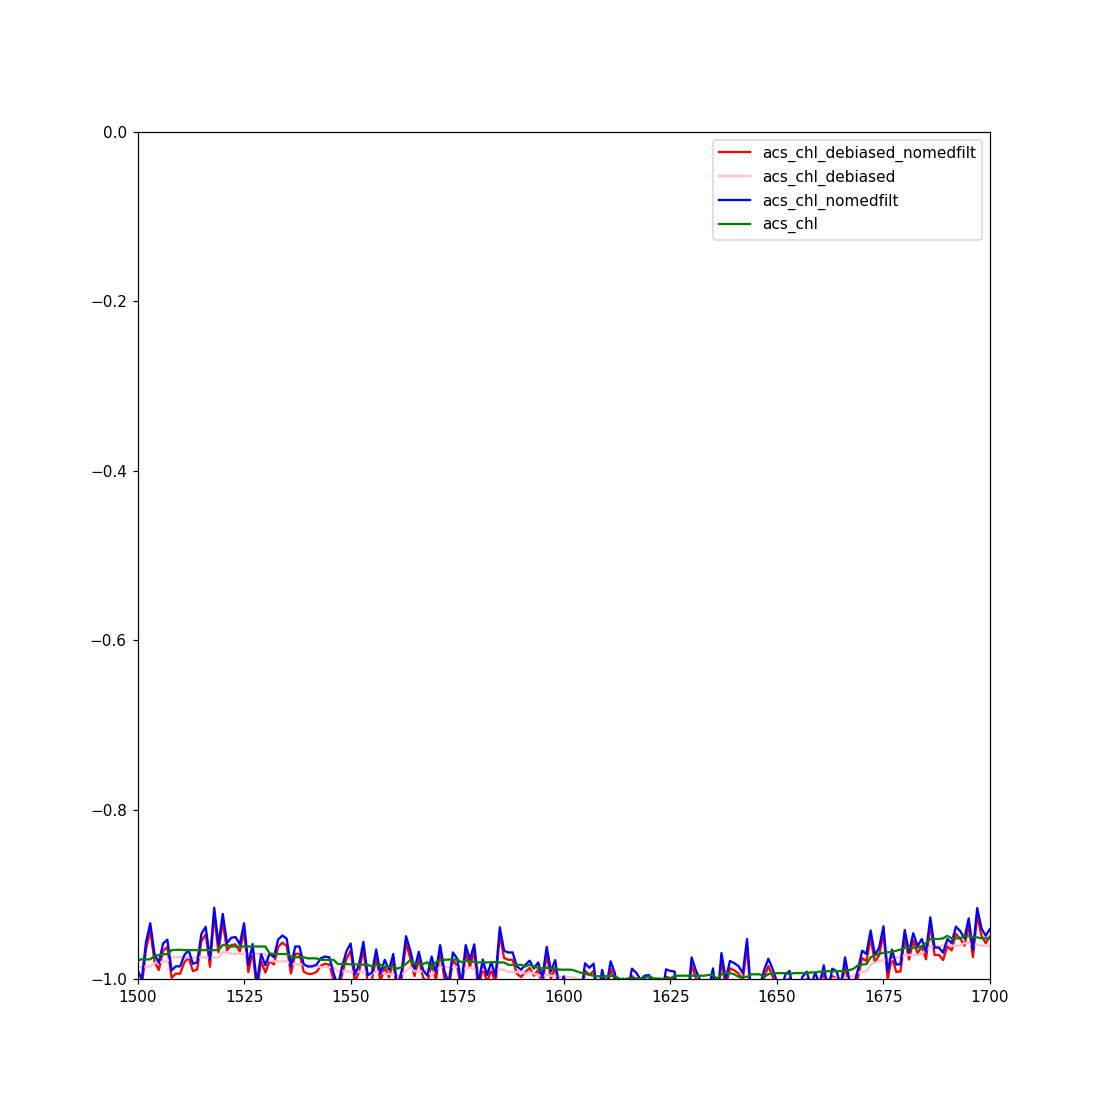

/tmp/ipykernel_305230/3145473309.py:28: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(acs_filtered_xyz['acs_chl_debiased_nomedfilt'].values), color='red', label ='acs_chl_debiased_nomedfilt')
/tmp/ipykernel_305230/3145473309.py:30: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(acs_filtered_xyz['acs_chl_nomedfilt'].values), color='blue', label ='acs_chl_nomedfilt')


In [81]:
plt.figure()
plt.plot(acs_filtered_xyz.uway_lat[:])

#acs_filtered_xyz.uway_lat[:])
# repeat for ACS 2
#plt.figure()
#plt.plot(np.log10(acs['acs2_chl_debiased'].values[i2f][innan2]))
#ix = xr.DataArray(acs.time[i2f][innan2], dims=['time']) 
#acs2_filtered_x = acs.sel(time = ix)
#acs2_filtered_x['acs2_chl'].values = sg.medfilt(acs.acs2_chl[i2f][innan2], kernel_size=31) # apply med filter to acx chl and acx chl debiasesd 
#acs2_filtered_x['acs2_chl_debiased'].values = sg.medfilt(acs.acs2_chl_debiased[i2f][innan2], kernel_size=31)
#plt.plot(np.log10(acs2_filtered_x['acs2_chl_debiased'].values))

# step y - # filters w.r.t. ap (10the element) being > 0
#i2kp = np.where((acs2_filtered_x.acs2_ap[:,10] > 0))[0]
#iy = xr.DataArray(acs2_filtered_x.time[i2kp], dims=['time']) 
#acs2_filtered_xy = acs2_filtered_x.sel(time = iy)

# step z - # filters w.r.t. acs chl being > 0
#i2kp = np.where((acs2_filtered_xy.acs2_chl[:] > 0)) [0]
#iz = xr.DataArray(acs2_filtered_xy.time[i2kp], dims=['time']) 
#acs2_filtered_xyz = acs2_filtered_xy.sel(time = iz)

#plt.figure()
#plt.plot(acs2_filtered_xyz['uway_lat'], np.log10(acs2_filtered_xyz['acs2_chl_debiased'].values),color='red')
#plt.plot(acs2_filtered_x['uway_lat'], np.log10(acs2_filtered_x['acs2_chl_debiased'].values), color='pink')
plt.figure(figsize=(10,10))
plt.plot(np.log10(acs_filtered_xyz['acs_chl_debiased_nomedfilt'].values), color='red', label ='acs_chl_debiased_nomedfilt')
plt.plot(np.log10(acs_filtered_xyz['acs_chl_debiased'].values), color='pink', label ='acs_chl_debiased')
plt.plot(np.log10(acs_filtered_xyz['acs_chl_nomedfilt'].values), color='blue', label ='acs_chl_nomedfilt')
plt.plot(np.log10(acs_filtered_xyz['acs_chl'].values), color='green', label ='acs_chl')
plt.xlim(1500,1700)
plt.ylim(-1,-0)
plt.legend()

In [82]:
acs_filtered2 = acs_filtered_xyz
#acs_filtered2 = acs_filtered2.rename_vars({'time_': 'time'}, )

<IPython.core.display.Javascript object>


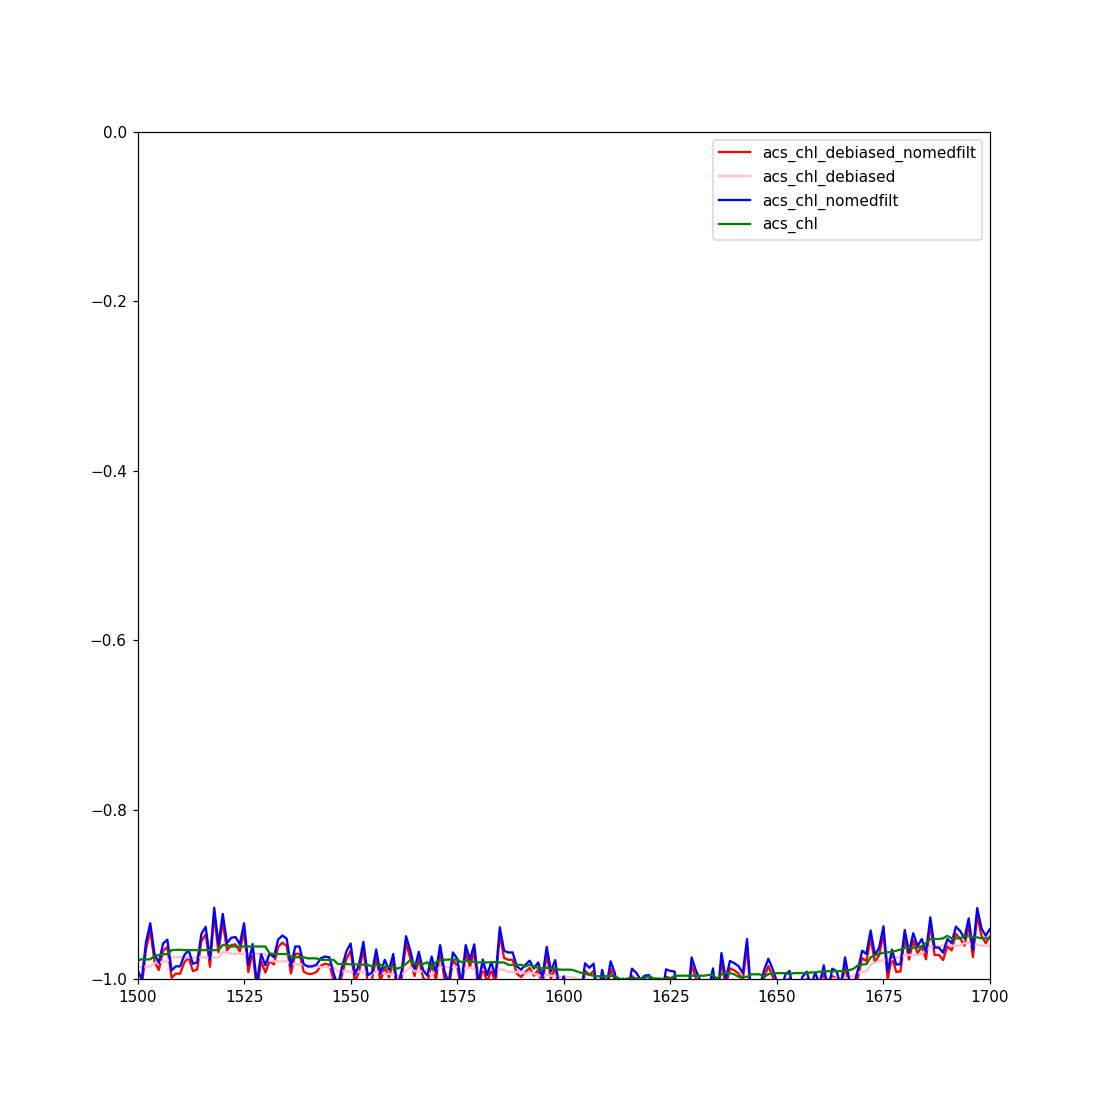

/tmp/ipykernel_305230/1093737856.py:2: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(acs_filtered_xyz['acs_chl_debiased_nomedfilt'].values), color='red', label ='acs_chl_debiased_nomedfilt')
/tmp/ipykernel_305230/1093737856.py:4: RuntimeWarning: invalid value encountered in log10
  plt.plot(np.log10(acs_filtered_xyz['acs_chl_nomedfilt'].values), color='blue', label ='acs_chl_nomedfilt')


In [83]:
plt.figure(figsize=(10,10))
plt.plot(np.log10(acs_filtered_xyz['acs_chl_debiased_nomedfilt'].values), color='red', label ='acs_chl_debiased_nomedfilt')
plt.plot(np.log10(acs_filtered_xyz['acs_chl_debiased'].values), color='pink', label ='acs_chl_debiased')
plt.plot(np.log10(acs_filtered_xyz['acs_chl_nomedfilt'].values), color='blue', label ='acs_chl_nomedfilt')
plt.plot(np.log10(acs_filtered_xyz['acs_chl'].values), color='green', label ='acs_chl')
plt.xlim(1500,1700)
plt.ylim(-1,-0)
plt.legend()

<IPython.core.display.Javascript object>


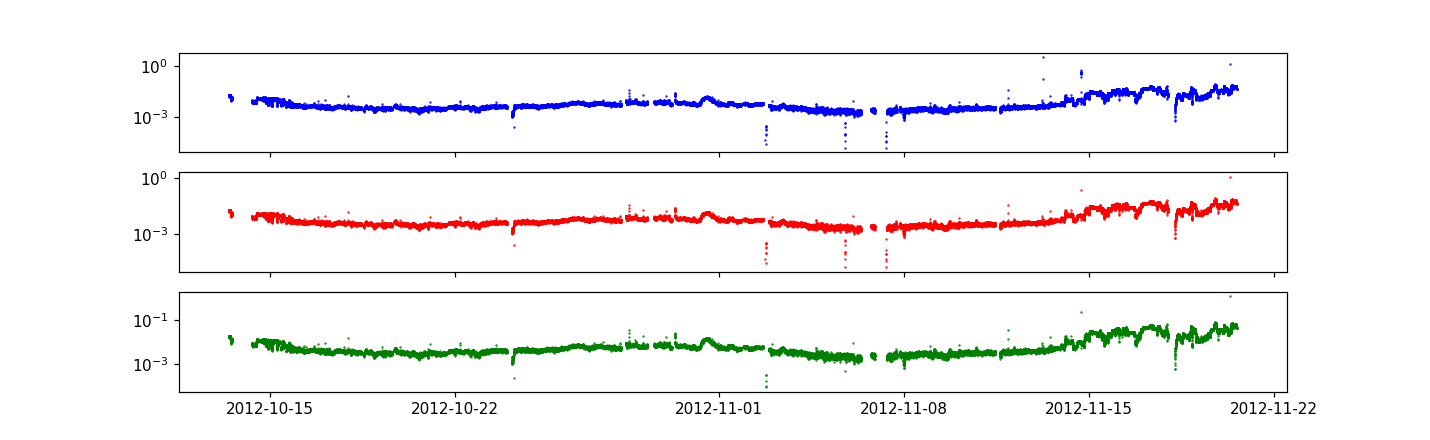

In [84]:
# plot to check                   
#iwv = np.where(acs_filtered.acs_wv==490)[0]
#fig, [ax, ax2] = plt.subplots(2,1, figsize=(13, 4), sharex=True)

#ax.semilogy(acs_filtered.time_[:], acs_filtered.acs_ap[:,iwv], 'b.', ms=1)
# ax.semilogy(acs_filtered.time_[:], sg.medfilt(x, 151), 'b.', ms=1)
#ax.semilogy(acs_filtered2.time, acs_filtered2.acs_ap[:,iwv], 'ro', ms=1, mfc='none', alpha=0.5)
#ax.grid('on')

#ax2.grid('on')

fig, [ax, ax2, ax3] = plt.subplots(3,1, figsize=(13, 4), sharex=True)

iwv = np.where(acs_filtered_x.acs_wv==490)[0]
ax.semilogy(acs.time[:], acs.acs_ap[:,iwv], 'b.', ms=1)

iwv_x = np.where(acs_filtered_x.acs_wv==490)[0]
ax2.semilogy(acs_filtered_x.time[:], acs_filtered_x.acs_ap[:,iwv_x], 'r.', ms=1)

iwv_y = np.where(acs_filtered_xy.acs_wv==490)[0]
ax3.semilogy(acs_filtered_xy.time[:], acs_filtered_xy.acs_ap[:,iwv_y], 'g.', ms=1)
#ax.semilogy(acs_filtered.time[:], sg.medfilt(x, 151), 'b.', ms=1)
#ax.semilogy(acs_filtered2.time, acs_filtered2.acs_ap[:,iwv], 'ro', ms=1, mfc='none', alpha=0.5)
#ax.grid('on')


In [85]:
# save to file for Silvia
# acs_out.to_csv('AMT29_ACS_chl_debiased.csv')
#acs_filtered2 = acs_filtered_xyz 

#print(len(acs_filtered_xyz['time']))
#print(len(acs2_filtered_xyz['time']))

#key_string = acs_filtered_xyz.keys()
#hplc_keys = [s for s in key_string if "hplc" in s]
#other_keys = [s for s in key_string if "hplc" not in s]

#data_vars='all'

#acs_filtered2  = xr.concat([acs_filtered_xyz, acs2_filtered_xyz],data_vars=other_keys,dim='time') # combines the 2 filtered x-rays back into net cdf (hplc keys are common)




In [86]:
#test for similar keys between AMT24 and AMT29 (baseline)

#load AMT29 (baseline for netcdf)
path_nc_29 = '/data/lazarev1/backup/cruise_data/AMT29/Public_Read_Only_Copy/DY110_Public/Optics_group/Processed/Underway/Step3/amt29_final_with_debiased_chl.nc'
nc_data_29 = xr.open_dataset(path_nc_29)  


#test for common and unqiue keys
keys_22 = list(acs_filtered2.keys())
keys_29 = list(nc_data_29.keys())
common_keys = set(keys_22).intersection(set(keys_29)) # keys contained in both cruises
extra_keys_22 =  set(keys_22) ^ common_keys # extra keys in AMT 28
extra_keys_29 = set(keys_29) ^ common_keys # extra keys in AMT29

print('common keys')
print(sorted(common_keys))

print('/n extra keys in amt22')
print(sorted(extra_keys_22))


print('/n extra keys in amt29')
print(sorted(extra_keys_29))


# manual clean up of AMT 22 keys
# acs_filtered_xy = acs_filtered_xy.rename_vars({"uway_lon": "uway_long"})
# acs_filtered_xy = acs_filtered_xy.drop("ac9_N")
# acs_filtered_xy = acs_filtered_xy.drop("ac9_chl")

# manual clean up of AMT 22 keys
acs_filtered2 = acs_filtered2.drop('ac9_N')
acs_filtered2 = acs_filtered2.drop('ac9_ap')
acs_filtered2 = acs_filtered2.drop('ac9_ap_u')
acs_filtered2 = acs_filtered2.drop('ac9_bp')
acs_filtered2 = acs_filtered2.drop('ac9_bp_u')
acs_filtered2 = acs_filtered2.drop('ac9_chl')
acs_filtered2 = acs_filtered2.drop('ac9_cp')
acs_filtered2 = acs_filtered2.drop('ac9_cp_u')
acs_filtered2 = acs_filtered2.drop('ac9_wv')

acs_filtered2 = acs_filtered2.drop('acs2_N')
acs_filtered2 = acs_filtered2.drop('acs2_ap')
acs_filtered2 = acs_filtered2.drop('acs2_ap_u')
acs_filtered2 = acs_filtered2.drop('acs2_bp')
acs_filtered2 = acs_filtered2.drop('acs2_bp_u')
acs_filtered2 = acs_filtered2.drop('acs2_chl')
acs_filtered2 = acs_filtered2.drop('acs2_cp')
acs_filtered2 = acs_filtered2.drop('acs2_cp_u')
acs_filtered2 = acs_filtered2.drop('acs2_wv')

acs_filtered2 = acs_filtered2.rename_vars({"hplc_Chl_c12": "hplc_Chl_c1c2"})
acs_filtered2 = acs_filtered2.rename_vars({"hplc_Original_PI_Sample_Label": "hplc_label"})
acs_filtered2 = acs_filtered2.rename_vars({"hplc_TAcc": "hplc_Tacc"})
acs_filtered2 = acs_filtered2.rename_vars({"hplc_TCaro": "hplc_Tcar"})
                                         
# acs_filtered_xy = acs_filtered_xy.drop("ac9_N")
# acs_filtered_xy = acs_filtered_xy.drop("ac9_chl")



# clean-up extra pigments




#print('/n extra keys in amt29')
#print(sorted(extra_keys_29))

#print('/n extra keys in amt26')
#print(sorted(extra_keys_26))
#sorted(acs_filtered2.keys())

common keys
['acs_N', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_chl', 'acs_chl_debiased', 'acs_cp', 'acs_cp_u', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp', 'bb3_bbp_corr', 'bb3_bbp_err', 'cstar_cp', 'cstar_cp_err', 'flow', 'hplc_Allo', 'hplc_Alpha-beta-Car', 'hplc_But-fuco', 'hplc_Chl_c3', 'hplc_Chlide_a', 'hplc_DP', 'hplc_DV_Chl_a', 'hplc_DV_Chl_b', 'hplc_Diadino', 'hplc_Diato', 'hplc_Fuco', 'hplc_Gyro', 'hplc_Hex-fuco', 'hplc_Lut', 'hplc_MV_Chl_a', 'hplc_MV_Chl_b', 'hplc_Neo', 'hplc_PI', 'hplc_PPC', 'hplc_PSC', 'hplc_PSP', 'hplc_Perid', 'hplc_Phide_a', 'hplc_Phytin_a', 'hplc_Pras', 'hplc_Tot_Chl_a', 'hplc_Tot_Chl_b', 'hplc_Tot_Chl_c', 'hplc_Viola', 'hplc_Zea', 'hplc_comments', 'hplc_lat', 'hplc_lon', 'uway_air_temp', 'uway_fluo', 'uway_heading', 'uway_humidity', 'uway_lat', 'uway_sal', 'uway_sst', 'uway_trans', 'uway_wind_dir']
/n extra keys in amt22
['ac9_N', 'ac9_ap', 'ac9_ap_u', 'ac9_bp', 'ac9_bp_u', 'ac9_chl', 'ac9_cp', 'ac9_cp_u', 'acs2_N', 'acs2_ap', 'acs2_ap_u', 'acs2_bp', '

In [90]:

acs_filtered2 = acs_filtered2.drop('hplc_date_extracted_(month/day/year)')

In [94]:

acs_filtered2 = acs_filtered2.rename_vars({"hplc_TChl": "hplc_Tchl"})
acs_filtered2 = acs_filtered2.rename_vars({"hplc_TPg": "hplc_Tpg"})
                                         

In [97]:
print(sorted(acs_filtered2.keys()))

acs_filtered2 = acs_filtered2.rename_vars({"hplc_Sampling_Depth_(meters)": "hplc_depth"})

['acs_N', 'acs_ap', 'acs_ap_u', 'acs_bp', 'acs_bp_u', 'acs_chl', 'acs_chl_debiased', 'acs_chl_debiased_nomedfilt', 'acs_chl_nomedfilt', 'acs_cp', 'acs_cp_u', 'bb3_bb02', 'bb3_bb02_err', 'bb3_bbp', 'bb3_bbp_corr', 'bb3_bbp_err', 'cstar_cp', 'cstar_cp_err', 'flow', 'hplc_Allo', 'hplc_Alpha-beta-Car', 'hplc_Bottle_Number', 'hplc_But-fuco', 'hplc_Chl_c1c2', 'hplc_Chl_c3', 'hplc_Chlide_a', 'hplc_Cruise_Name', 'hplc_DP', 'hplc_DV_Chl_a', 'hplc_DV_Chl_b', 'hplc_Day_of_Gregorian_Month', 'hplc_Diadino', 'hplc_Diato', 'hplc_Filter_Diameter_(mm)', 'hplc_Filter_storage_before_shipping_to_GSFC', 'hplc_Filter_type', 'hplc_Fuco', 'hplc_GSFC_Lab_sample_code', 'hplc_Gregorian_Month', 'hplc_Gyro', 'hplc_Hex-fuco', 'hplc_Indicate_if_filters_are_replicates', 'hplc_Lut', 'hplc_MV_Chl_a', 'hplc_MV_Chl_b', 'hplc_Name_of_Water_Body', 'hplc_Neo', 'hplc_PI', 'hplc_PPC', 'hplc_PSC', 'hplc_PSP', 'hplc_Perid', 'hplc_Phide_a', 'hplc_Phytin_a', 'hplc_Pras', 'hplc_Sequential_Day_of_Year', 'hplc_Sequential_Sample_Numb

ValueError: cannot rename 'hplc_Sampling_Depth_(meters)' because it is not a variable or coordinate in this dataset

In [98]:
# save updated NetCDF file


acs_filtered2 = acs_filtered2.drop('hplc_date_extracted_(month/day/year)')


acs_filtered2.to_netcdf(DIN_acs + fn_acs[:-3] + '_with_debiased_chl.nc')
acs_filtered2.close()


In [90]:
print(acs_filtered2)

<xarray.Dataset>
Dimensions:                                           (time: 37009,
                                                       acs_wv: 176, bb3_wv: 3,
                                                       hplc_time: 226)
Coordinates:
  * time                                              (time) datetime64[ns] 2...
  * acs_wv                                            (acs_wv) float64 400.0 ...
  * bb3_wv                                            (bb3_wv) float64 470.0 ...
  * hplc_time                                         (hplc_time) datetime64[ns] ...
Data variables: (12/101)
    flow                                              (time) float64 57.89 .....
    acs_chl                                           (time) float64 0.1841 ....
    acs_ap                                            (time, acs_wv) float64 ...
    acs_ap_u                                          (time, acs_wv) float64 ...
    acs_bp                                            (time, acs_wv) float6

<IPython.core.display.Javascript object>


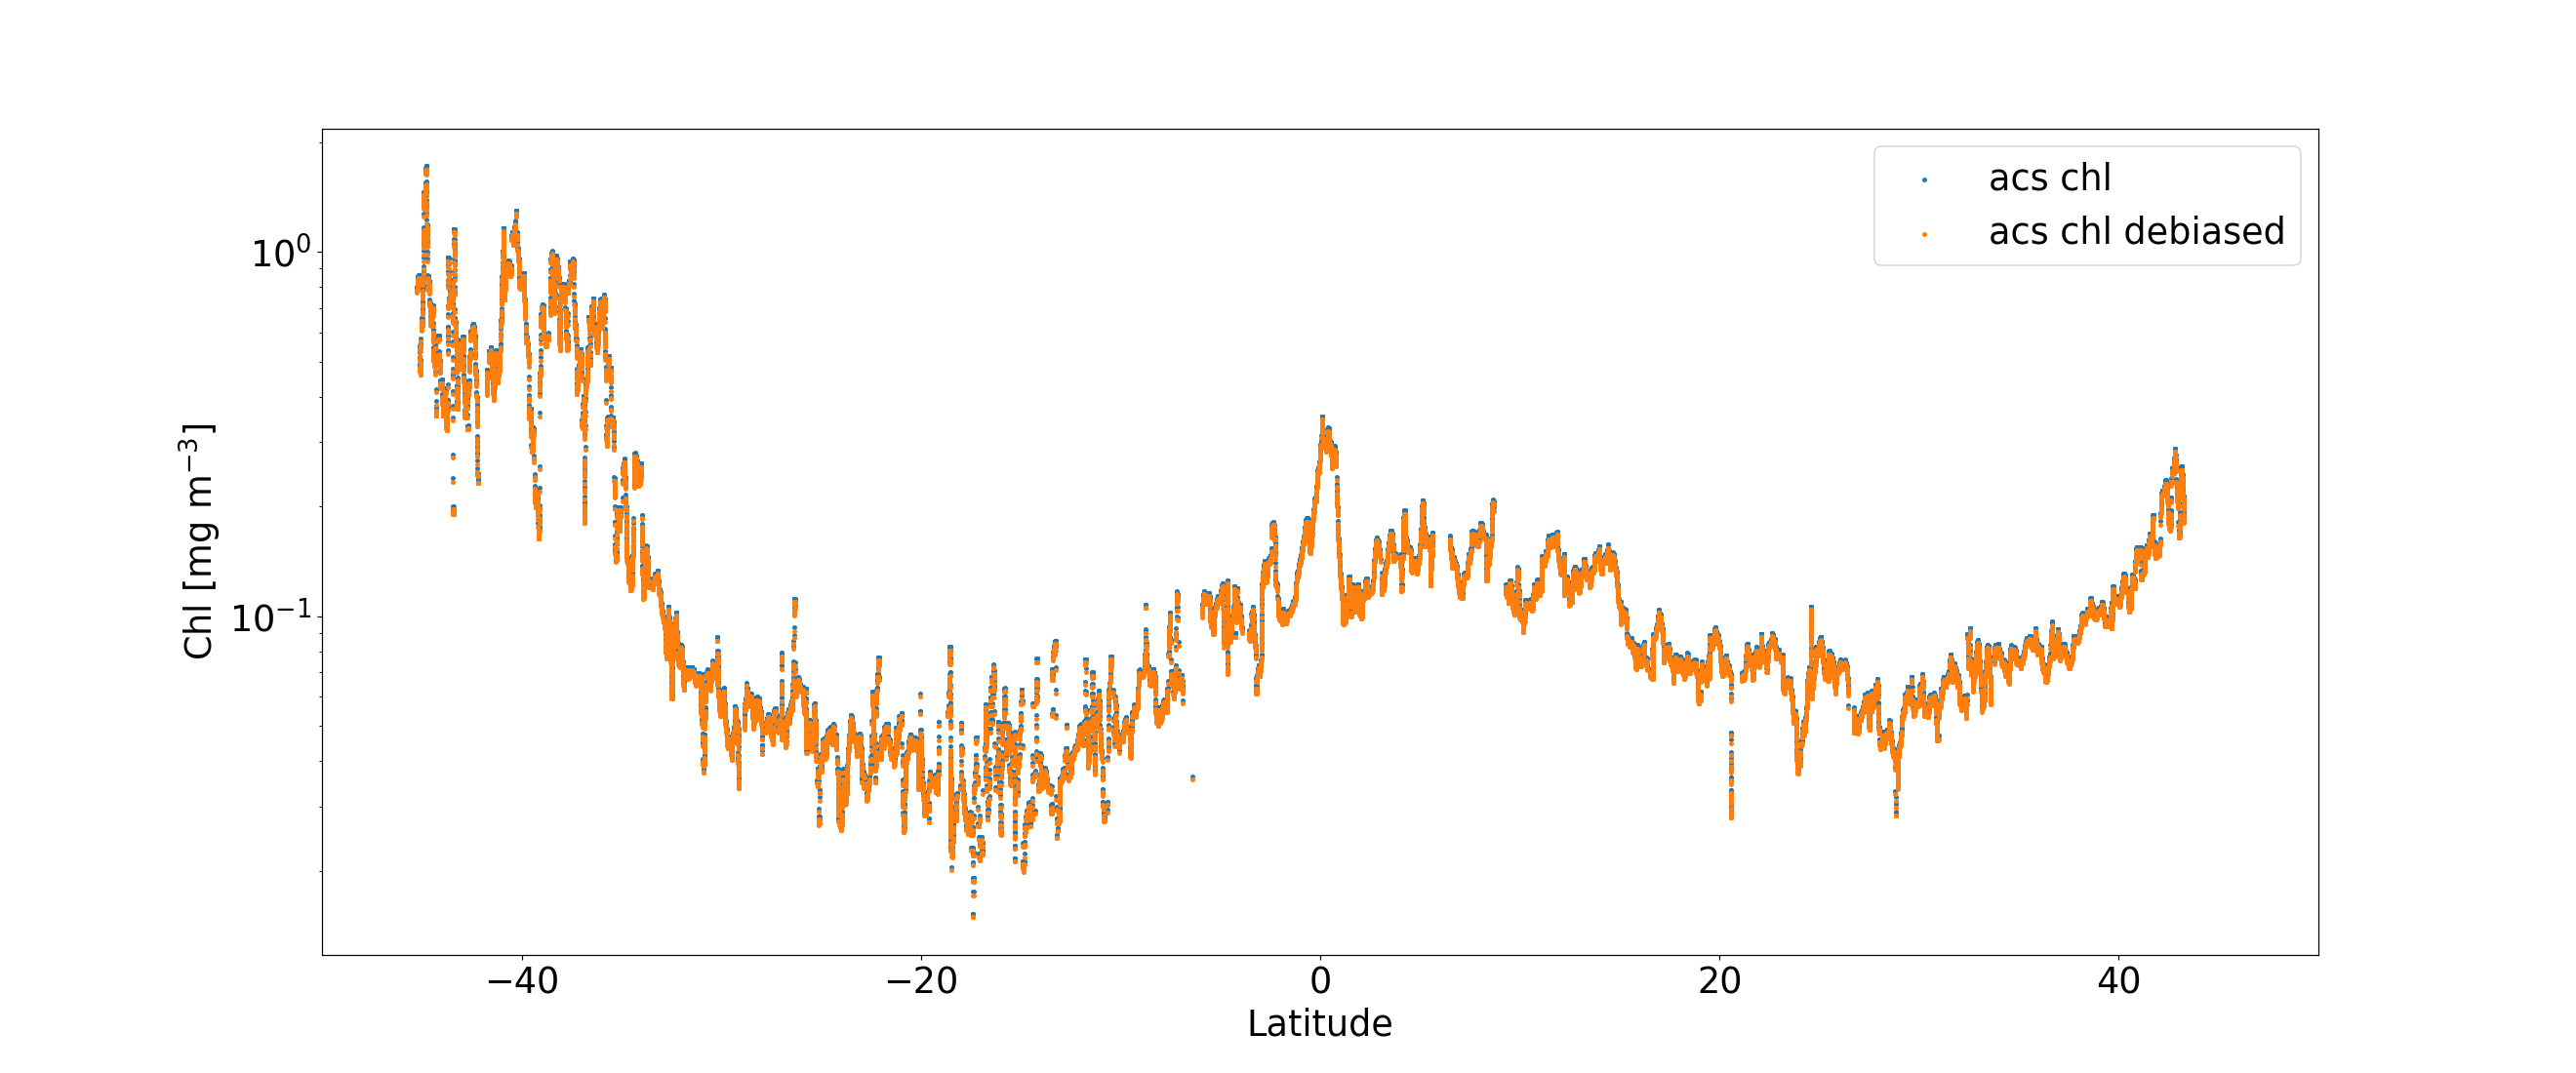

Text(0, 0.5, 'Chl [mg m$^{-3}$]')

In [91]:

# plot to show debiassing of chl
plt.figure(figsize=(24,10))
plt.rc('font', size=24)

plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['acs_chl'], s=5,label='acs chl ')
plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['acs_chl_debiased'], s=5,label='acs chl debiased')
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel('Latitude')
plt.xlim(-50,50)
plt.ylabel('Chl [mg m$^{-3}$]')
    

<IPython.core.display.Javascript object>


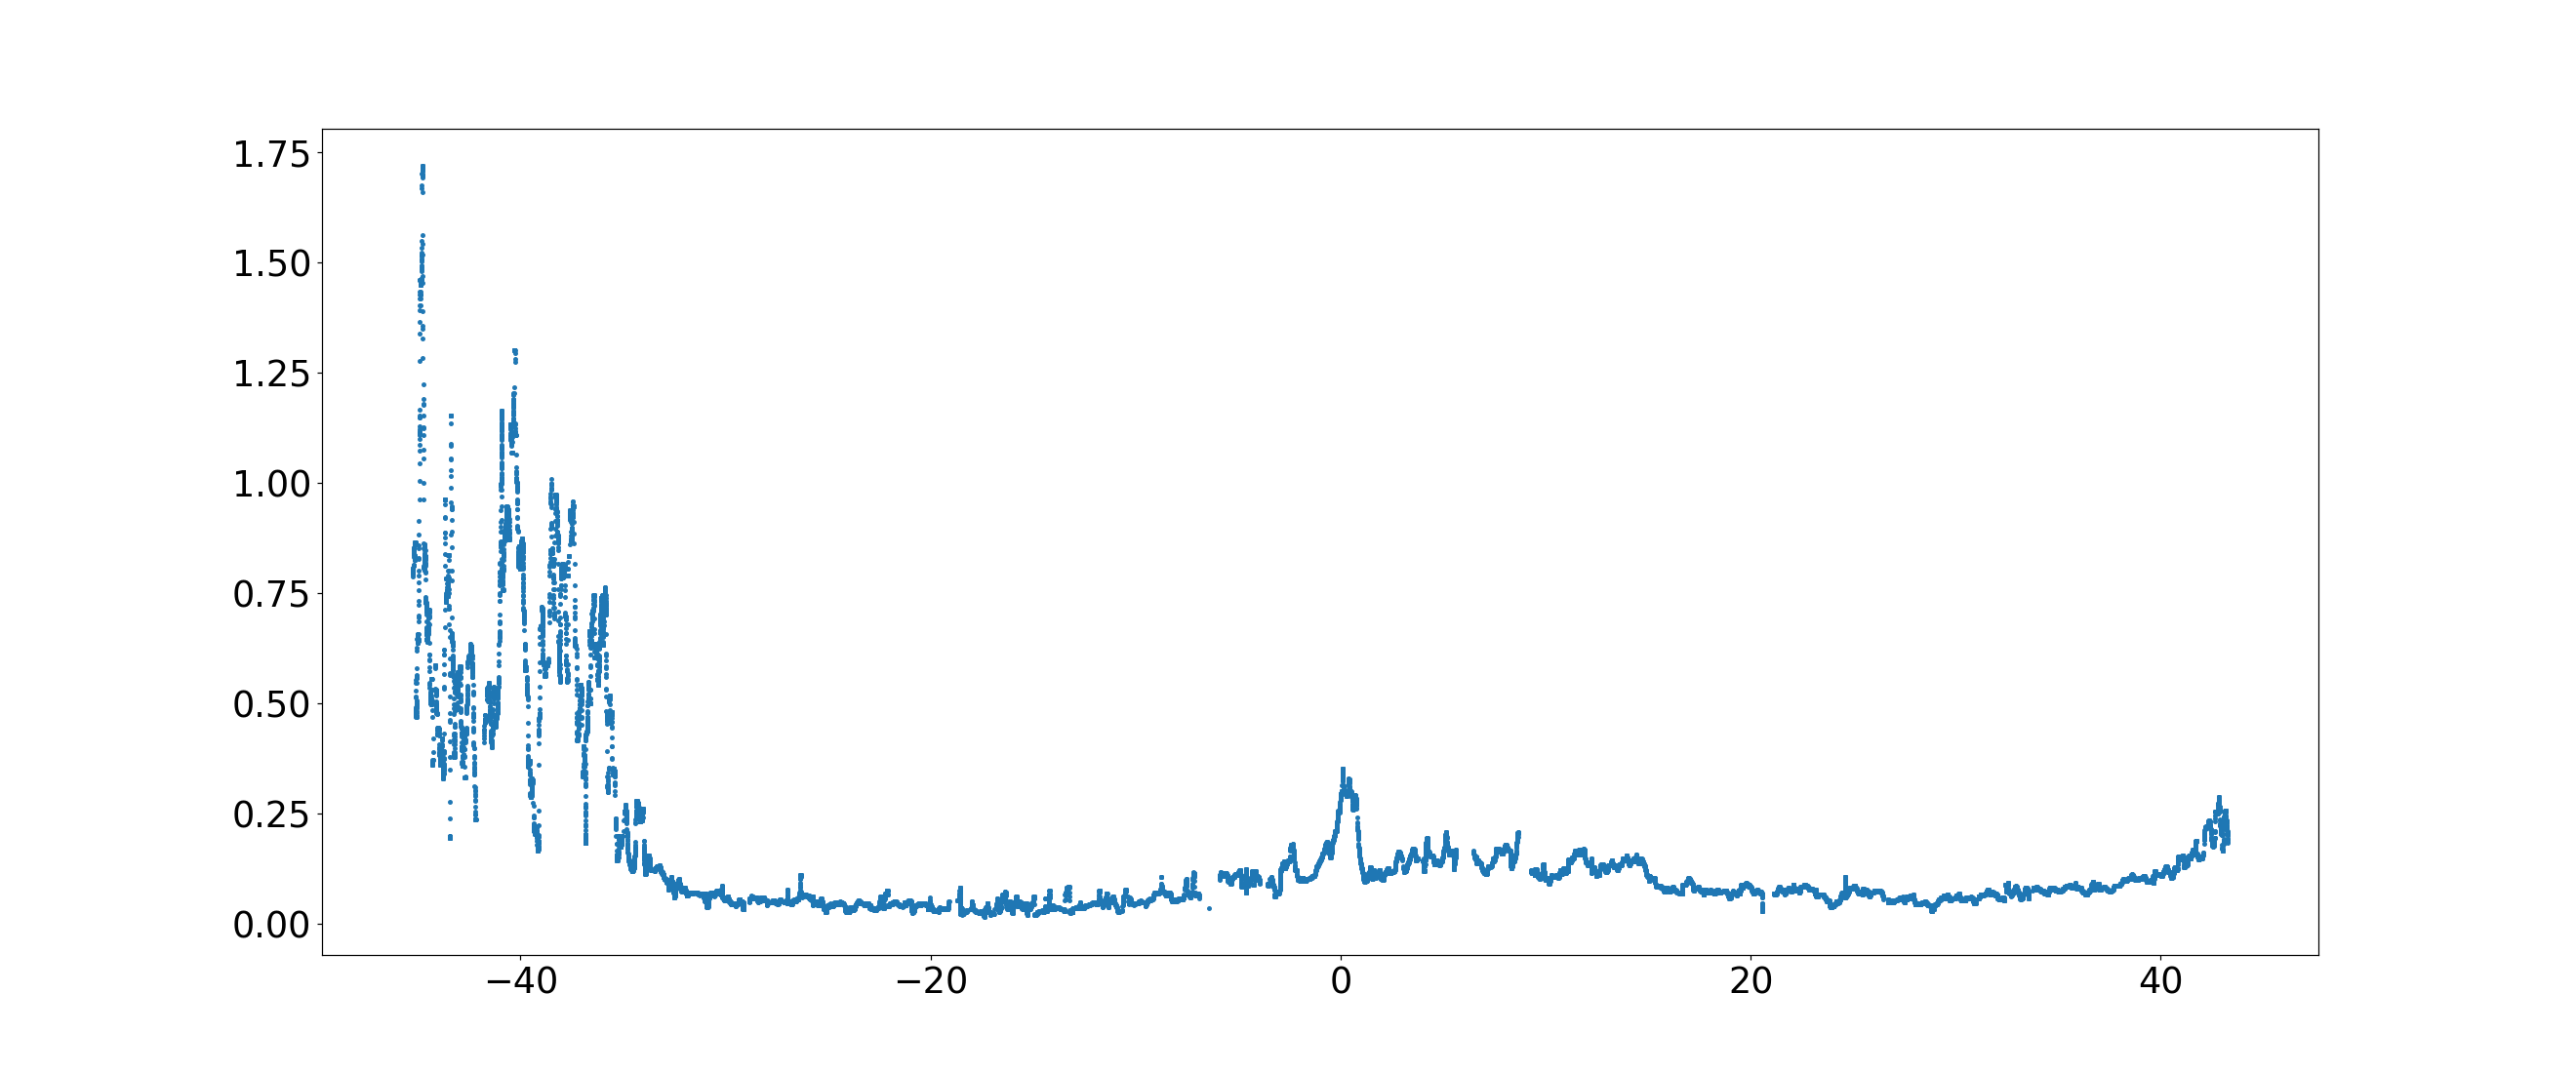

KeyError: 'ac9_chl'

In [92]:
# plot to show acs and ac9 chl separately
plt.figure(figsize=(24,10))
plt.rc('font', size=24)

plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['acs_chl'], s=5,label='acs chl ')
plt.scatter(acs_filtered2['uway_lat'], acs_filtered2['ac9_chl'], s=5,label='ac9 chl')
plt.gca().set_yscale('log')
plt.legend()
plt.xlabel('Latitude')
plt.xlim(-50,50)
plt.ylabel('Chl [mg m$^{-3}$]')

In [ ]:
plt.i
plt.plot(acs_filtered2['acs_chl'])

plt.plot(acs_filtered2['ac9_chl'])

In [ ]:
list(acs_filtered2.keys())